# LGN Unit Analysis

Looking at how many LGN units are needed in the model.

January 17, 2024

In [1]:
import sys
import os

myhost = os.uname()[1]
print("Running on Computer: [%s]" %myhost)

sys.path.insert(0, '/home/ifernand/Code/') 
dirname = '/home/ifernand/Cloud_SynthData_Proj'

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import io as sio
import seaborn as sns
import torch
import time
import h5py

# NDN tools
import NDNT
import NDNT.utils as utils
from NDNT.modules.layers import *
from NDNT.networks import *
import NDNT.NDN as NDN
from NTdatasets.conway.synthcloud_datasets import SimCloudData
from NTdatasets.generic import GenericDataset
from ColorDataUtils.multidata_utils import MultiExperiment
import ColorDataUtils.ConwayUtils as CU
from ColorDataUtils import readout_fit
from ColorDataUtils.simproj_utils import *
from NDNT.utils import fit_lbfgs, fit_lbfgs_batch
from NDNT.utils import imagesc   
from NDNT.utils import ss
from NDNT.utils import subplot_setup
from NDNT.utils import figure_export

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

%load_ext autoreload
%autoreload 2

Running on Computer: [sc]
Invoking __init__.py for NDNT.utils


## Load Data

In [2]:
start    = time.time()
data     = SimCloudData(cell_type_list=['V1_Exc_L4', 'V1_Inh_L4', 'V1_Exc_L2/3', 'V1_Inh_L2/3'], res_frac=2, down_sample=2, num_lags=22)
end      = time.time()
print('CPU Time', end-start, 'sec')

CPU Time 67.93838834762573 sec


In [3]:
# Load baseline LL
GLM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GLM_LL.pkl', allow_pickle=True)
GQM_LL = np.load('data/cloud_data_stim_dim_120_sqrad_0.3_GQM_LL.pkl', allow_pickle=True)

In [4]:
cell_idx_dict = data.cell_idx_dict
thetas_dict = data.thetas
V1_thetas = np.concatenate((thetas_dict['V1_Exc_L4'], thetas_dict['V1_Inh_L4'], thetas_dict['V1_Exc_L2/3'], thetas_dict['V1_Inh_L2/3']))
mu0s = data.mu0s

In [5]:
L4_exc_idx = cell_idx_dict['V1_Exc_L4']
L4_inh_idx = cell_idx_dict['V1_Inh_L4']
L23_exc_idx = cell_idx_dict['V1_Exc_L2/3']
L23_inh_idx = cell_idx_dict['V1_Inh_L2/3']

In [6]:
stim_dims = data.stim_dims
num_lags = data.num_lags
L  = stim_dims[1]
NC = data.NC
NT = data.NT
print('stim_dims =', stim_dims)
print('num_lags =', num_lags)
print('L =', L)
print('Number of cells', NC)
print('Number of time points', NT)

stim_dims = [1, 60, 60, 1]
num_lags = 22
L = 60
Number of cells 1491
Number of time points 1020000


## Degree to Qmu

In [7]:
def degrees2mu(theta_deg, angles, continuous=True, max_angle=180 ):
    """
    Converts degrees into mu-values. If to_output=True, outputs to an array, and otherwise
    stores in the Qmu variable. It detects whether half-circle of full circle using stored angle values
        
    Args:
        theta_deg (np array): array of angles in degrees into mu values, based on 180 or 360 deg wrap-around
        continuous (Boolean): whether to convert to continuous angle or closest "integer" mu value (def True, continuous)
        max_angle: maximum angle represented in OriConv layers (default 180, but could be 360)
    Returns:
        Qmus: as numpy-array, if to_output is set to True, otherwise, nothing 
    """
    num_angles = len(angles)

    # convert inputs to np.array
    if not isinstance(theta_deg, np.ndarray):
        theta_deg = np.array(theta_deg, dtype=np.float32)
    if not continuous:
        dQ = max_angle/num_angles
        theta_deg = dQ * np.round(theta_deg/dQ)
    theta_deg = (theta_deg%max_angle)  # map between 0 and max_angle

    mu_offset = 1/num_angles # first bin at 0 degrees is actually a shifted mu value (not right at edge)
    Qmus = (theta_deg-max_angle/2) / (max_angle/2) + mu_offset
    Qmus[Qmus <= -1] += 2
    Qmus[Qmus > 1] += -2
    
    return Qmus

In [8]:
angles = np.arange(0, 180, 30).astype(int)
Qmu0s = degrees2mu(V1_thetas, angles)
print('Angle mu0:', Qmu0s.shape)

Angle mu0: (1491,)


## Create Model

In [9]:
# Adam Parameters
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=1,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay=0.2, accumulated_grad_batches=3)
adam_pars['device'] = device

In [10]:
XTreg = 10.0
Xreg0 = 1.0 # d2/dx
Creg0 = 0.05 # center

Xreg1 = 0.05 # d2/dx
Creg1 = 0.001 # center

MaxReg = 0.001

angle_mode = 'nearest' # 'bilinear'

NQ = len(angles)

num_LGN_units = [1,2] #,3,4]
num_repeat = 10
models = {}
fws = [19, 19, 5, 5]

for i in range(len(num_LGN_units)):
    num_subs = [num_LGN_units[i], 24, 16, 16]  

    # LGN LAYER
    clayersQ = [STconvLayer.layer_dict( 
        input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
        filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
        padding='circular', output_norm='batch', window='hamming', initialize_center=True,
        reg_vals={'d2xt':XTreg, 'd2x':Xreg0, 'center': Creg0} )]

    # PROJECTION LAYER
    clayersQ.append(
        OriConvLayer.layer_dict(
            num_filters=num_subs[1], num_inh=num_subs[1]//2,
            filter_width=fws[1], NLtype='relu', norm_type=1,
            bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center=True, 
            reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

    # TIME SHIFT LAYER
    clayersQ.append(TimeShiftLayer.layer_dict())

    # REST
    for ii in range(2,len(fws)):
        clayersQ.append(OriConvLayer.layer_dict( 
            num_filters=num_subs[ii], num_inh=num_subs[ii]//2, bias=False, norm_type=1, 
            filter_width=fws[ii], NLtype='relu',
            output_norm='batch', initialize_center=True, #window='hamming', 
            angles=angles) )
        
    scaffold_netQ =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

    readout_parsQ = ReadoutLayerQsample.layer_dict(
        num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
        reg_vals={'max': MaxReg})

    readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

    for k in range(num_repeat):
        models[str(num_LGN_units[i])+' LGN Units '+str(k)] = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson', seed=100+k)
        print('Model', i, k, 'created')

Model 0 0 created
Model 0 1 created
Model 0 2 created
Model 0 3 created
Model 0 4 created
Model 0 5 created
Model 0 6 created
Model 0 7 created
Model 0 8 created
Model 0 9 created
Model 1 0 created
Model 1 1 created
Model 1 2 created
Model 1 3 created
Model 1 4 created
Model 1 5 created
Model 1 6 created
Model 1 7 created
Model 1 8 created
Model 1 9 created


In [11]:
LL_dict = {}
for i in range(len(num_LGN_units)):
    for k in range(num_repeat):
        cnn = models[str(num_LGN_units[i])+' LGN Units '+str(k)]
        cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
        cnn.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
        cnn.networks[1].layers[0].fit_mus(True)
        cnn.networks[1].layers[0].fit_Qmus(False)
        cnn.networks[1].layers[0].Qsample_mode = angle_mode
        cnn.block_sample = True

        start = time.time()
        cnn.fit(data, **adam_pars, verbose=False)
        end = time.time()

        cnn.save_model('models/LGN_testing_model_'+str(num_LGN_units[i])+'_units_'+str(k)+'_double_temp_res.ndn')

        LL_dict[str(num_LGN_units[i])+' LGN Units'] = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)

        print('Model', i, k, 'done fitting')

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_0_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:09<00:00,  1.02s/it]


Model 0 0 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_1_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.00s/it]


Model 0 1 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_2_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.01s/it]


Model 0 2 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_3_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:09<00:00,  1.02s/it]


Model 0 3 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_4_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.00s/it]


Model 0 4 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_5_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.01s/it]


Model 0 5 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_6_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:09<00:00,  1.03s/it]


Model 0 6 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_7_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:08<00:00,  1.01s/it]


Model 0 7 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_8_double_temp_res.ndn


Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [01:09<00:00,  1.02s/it]


Model 0 8 done fitting
  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
  Model saved:  models/LGN_testing_model_1_units_9_double_temp_res.ndn


Eval models:   0%|                                                                                                                                | 0/68 [00:00<?, ?it/s]

KeyboardInterrupt



In [12]:
LL_dict.keys()

dict_keys(['1 LGN Units'])

## Load Models

In [9]:
models = []
for k in range(9):
    models.append(NDN.load_model('models/LGN_testing_model_1_units_'+str(k)+'_double_temp_res.ndn'))

In [12]:
LL_dict = {}
for k in range(9):
    cnn = models[k]
    LL_dict['1 LGN Unit Model '+str(k)] = cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=1, null_adjusted=True)

Eval models:   0%|                                                                                                                               | 0/204 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.49 GiB. GPU  has a total capacity of 47.53 GiB of which 102.25 MiB is free. Process 1033405 has 28.87 GiB memory in use. Including non-PyTorch memory, this process has 17.24 GiB memory in use. Of the allocated memory 16.91 GiB is allocated by PyTorch, and 13.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Higher Temporal-Res Data

Text(0, 0.5, 'Log-Likelihood')

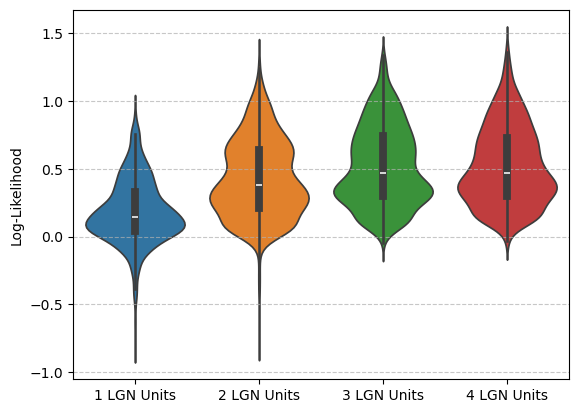

In [14]:
LL_to_plot = [] 
for i in range(len(num_LGN_units)):
    LL_to_plot.append(list(LL_dict[str(num_LGN_units[i])+' LGN Units']))
labels = list(LL_dict.keys())
sns.violinplot(data=LL_to_plot)
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Log-Likelihood')

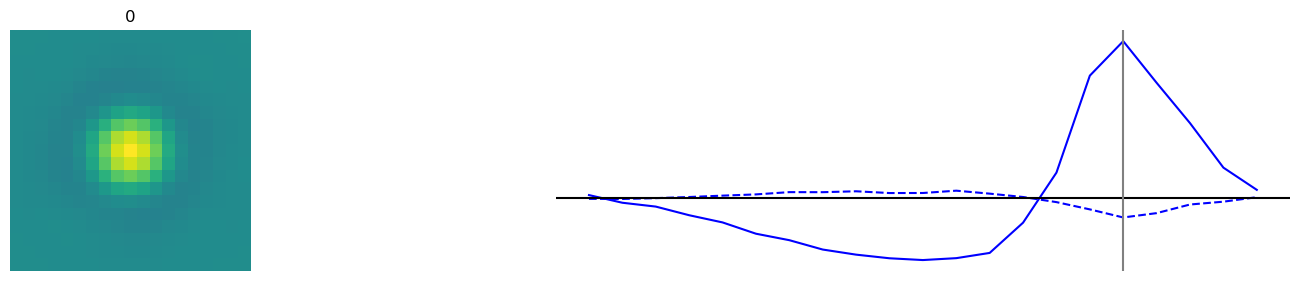

In [27]:
cnn = models[1]
cnn.plot_filters()

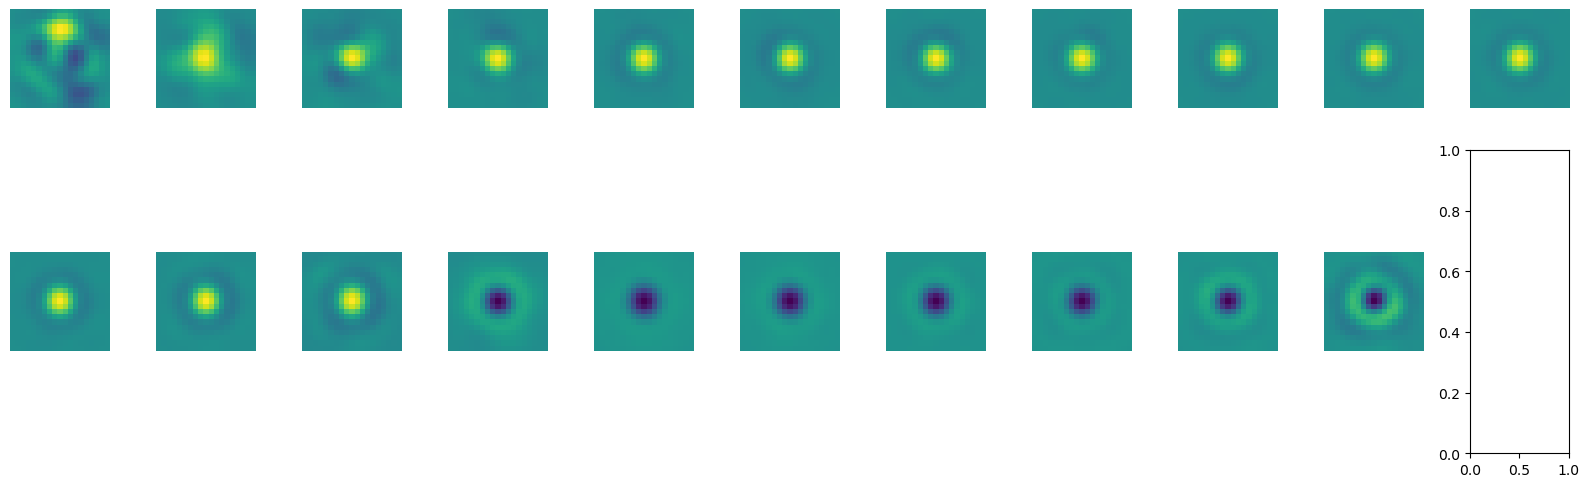

In [28]:
cnn = models[0]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
ss(2,11)
for i in range(21):
    plt.subplot(2,11,i+1)
    imagesc(filters[:,:,i,0], balanced=True)
    plt.axis('off')
plt.tight_layout()
plt.show()

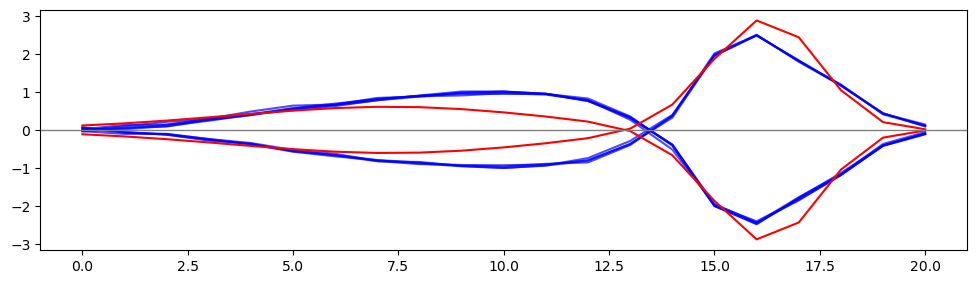

In [25]:
fws = [19,19,5,5]
subplot_setup(1, 1, row_height=3, fig_width=10)
for k in range(9):
    cnn = models[k]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)
    pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
    plt.plot(pred_temp/np.std(pred_temp), color='blue', alpha=0.7)
plt.plot(-1*true_temp[::-1]/np.std(true_temp), color='red')
plt.plot(true_temp[::-1]/np.std(true_temp),color='red')
plt.axhline(y=0, color='gray', lw=1)
plt.show()

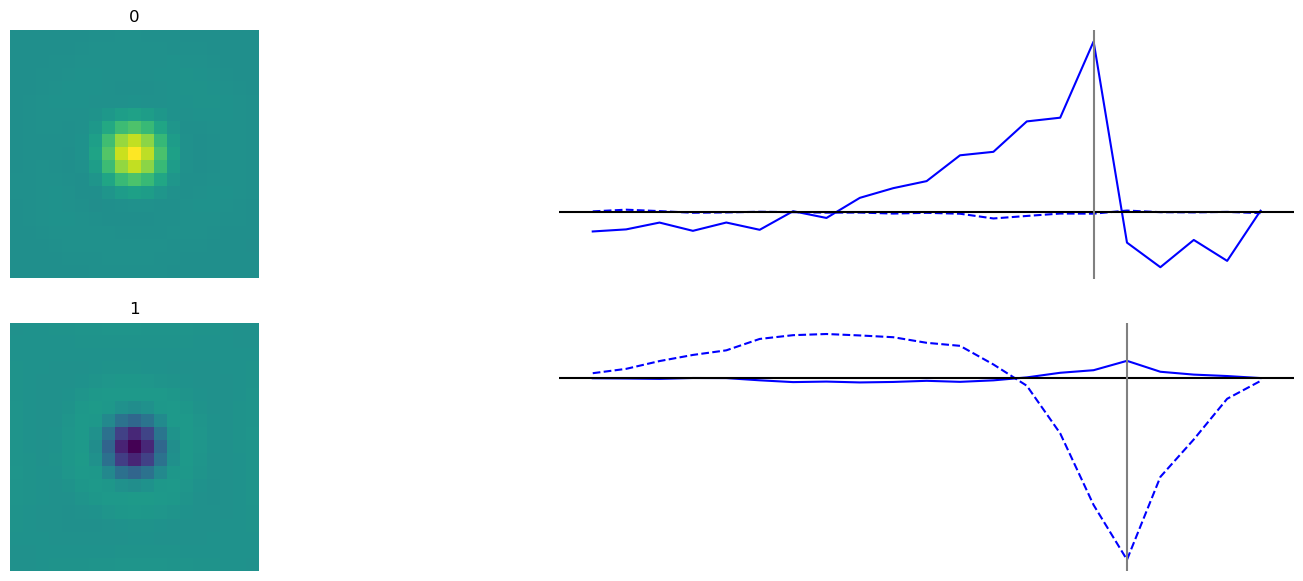

In [19]:
cnn = models['2 LGN Units 0']
cnn.plot_filters()

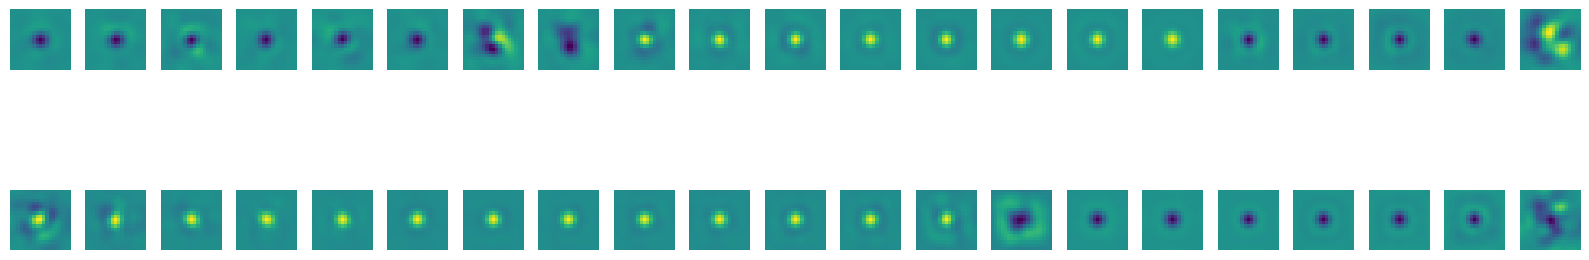

In [48]:
cnn = models['2 LGN Units 0']
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
ss(2,21)
for i in range(21):
    plt.subplot(2,21,i+1)
    imagesc(filters[:,:,i,0], balanced=True)
    plt.axis('off')
for i in range(21):
    plt.subplot(2,21,i+22)
    imagesc(filters[:,:,i,1], balanced=True)
    plt.axis('off')
plt.tight_layout()
plt.show()

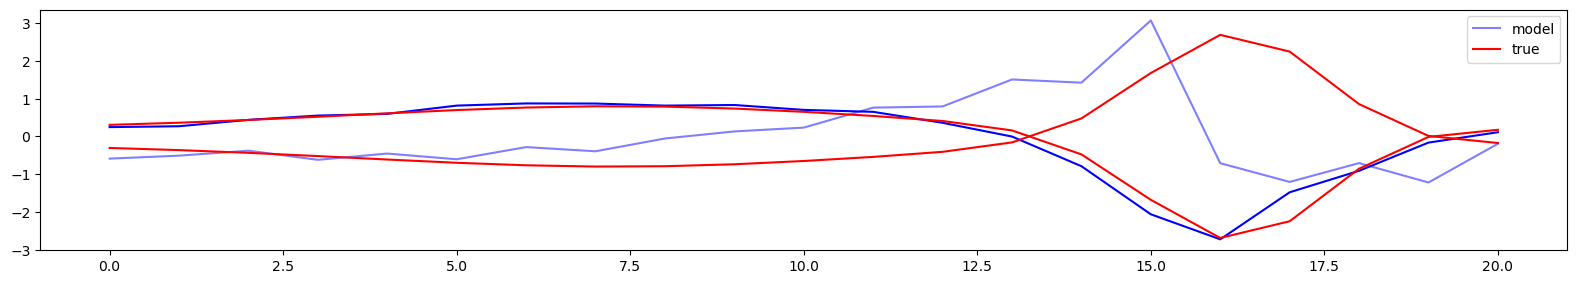

In [57]:
cnn = models['2 LGN Units 0']
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp[:,0]-np.mean(pred_temp[:,0]))/np.std(pred_temp[:,0]), label='model', color='blue', alpha=0.5)
plt.plot((pred_temp[:,1]-np.mean(pred_temp[:,1]))/np.std(pred_temp[:,1]), color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

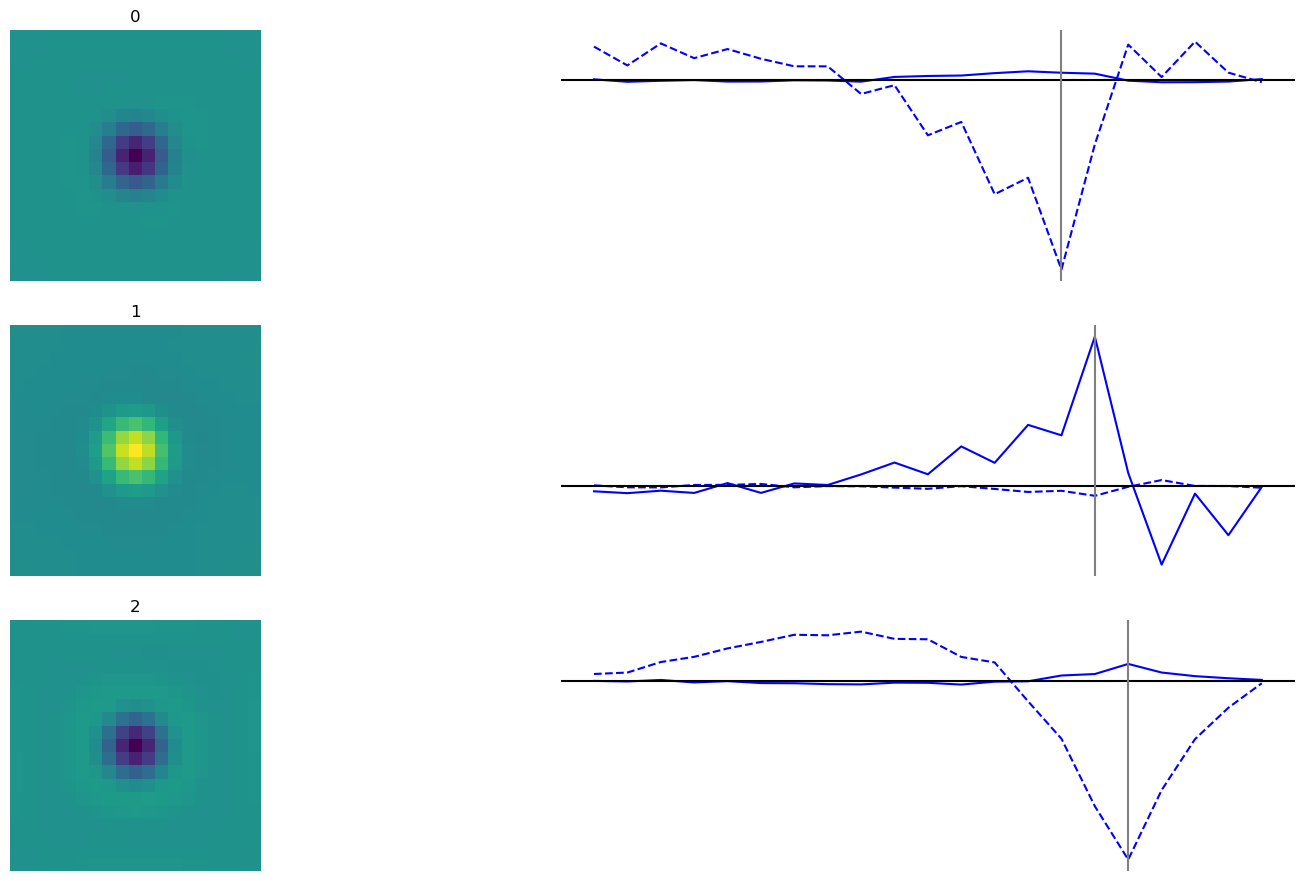

In [20]:
cnn = models['3 LGN Units 0']
cnn.plot_filters()

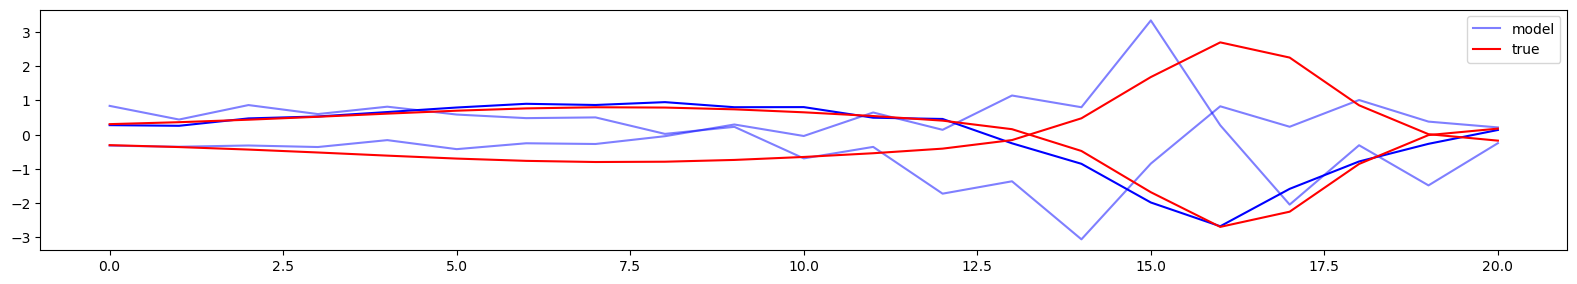

In [56]:
cnn = models['3 LGN Units 0']
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp[:,0]-np.mean(pred_temp[:,0]))/np.std(pred_temp[:,0]), label='model', color='blue',alpha=0.5)
plt.plot((pred_temp[:,1]-np.mean(pred_temp[:,1]))/np.std(pred_temp[:,1]), color='blue',alpha=0.5)
plt.plot((pred_temp[:,2]-np.mean(pred_temp[:,2]))/np.std(pred_temp[:,2]), color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

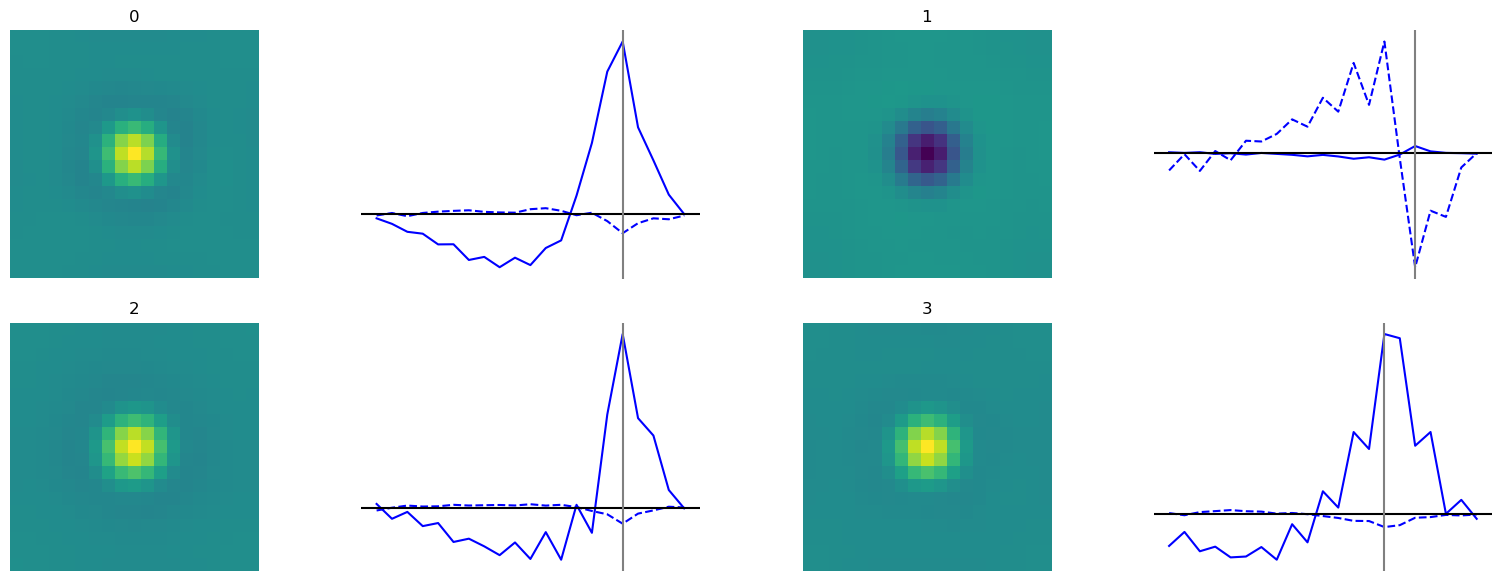

In [21]:
cnn = models['4 LGN Units 0']
cnn.plot_filters()

In [23]:
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
filters.shape

(19, 19, 21, 4)

## Big LGN Layer Model

In [122]:
num_subs = [12, 24, 16, 16]  

# LGN LAYER
clayersQ = [STconvLayer.layer_dict( 
            input_dims = data.stim_dims, num_filters=num_subs[0], norm_type=1,
            filter_dims=[1,fws[0],fws[0],num_lags-1] , bias=False, NLtype='relu',
            padding='circular', output_norm='batch', window='hamming', initialize_center=True,
            reg_vals={'d2xt':XTreg, 'd2x':Xreg0, 'center': Creg0} )]

# PROJECTION LAYER
clayersQ.append(OriConvLayer.layer_dict(
            num_filters=num_subs[1], num_inh=num_subs[1]//2,
            filter_width=fws[1], NLtype='relu', norm_type=1,
            bias=False, output_norm='batch', window='hamming', padding='circular', initialize_center=True, 
            reg_vals={'d2x':Xreg1, 'center': Creg1}, angles=angles) )

# TIME SHIFT LAYER
clayersQ.append(TimeShiftLayer.layer_dict())

# REST
for ii in range(2,len(fws)):
    clayersQ.append(OriConvLayer.layer_dict( 
            num_filters=num_subs[ii], num_inh=num_subs[ii]//2, bias=False, norm_type=1, 
            filter_width=fws[ii], NLtype='relu',
            output_norm='batch', initialize_center=True, #window='hamming', 
            angles=angles) )
        
scaffold_netQ =  FFnetwork.ffnet_dict(
        ffnet_type='scaffold3d', xstim_n='stim', layer_list=clayersQ, scaffold_levels=[1,3,4], num_lags_out=NQ)

readout_parsQ = ReadoutLayerQsample.layer_dict(
        num_filters=NC, NLtype='softplus', bias=True, pos_constraint=True,
        reg_vals={'max': MaxReg})

readout_netQ = FFnetwork.ffnet_dict(xstim_n = None, ffnet_n=[0], layer_list = [readout_parsQ], ffnet_type='readout')

LGN_12_cnn = NDN(ffnet_list = [scaffold_netQ, readout_netQ], loss_type='poisson')
LGN_12_cnn.networks[1].layers[0].mu.data = torch.tensor(mu0s, dtype=torch.float32)
LGN_12_cnn.networks[1].layers[0].Qmu.data[:,0] = torch.tensor(Qmu0s, dtype=torch.float32)
LGN_12_cnn.networks[1].layers[0].fit_mus(True)
LGN_12_cnn.networks[1].layers[0].fit_Qmus(False)
LGN_12_cnn.networks[1].layers[0].Qsample_mode = angle_mode
LGN_12_cnn.block_sample = True

LGN_12_cnn.info()

  ReadoutLayer: fitting mus
  ReadoutLayer: not fitting Qmus
NDN poisson, output net #1:
  0 scaffold3d: Input = 'stim' [1, 60, 60, 1], Scaffold levels = 1 3 4
    0 STconv10:  12 (i0)  [relu] w19  NBH	{'d2xt': 0.0001, 'd2x': 1.0, 'center': 0.05}
    1  oriconv:  24 (i12) [relu] w19  NBH	{'d2x': 0.05, 'center': 0.001}
    2   normal:   1 (i0)  [lin]    	
    3  oriconv:  16 (i8)  [relu] w5   NB	
    4  oriconv:  16 (i8)  [relu] w5   NB	
  1 readout: Input = ffnet 0 [56, 60, 60, 6]
    0 readQsmp: 1491 (i0)  [soft] B+	{'max': 0.001}


In [123]:
LGN_12_cnn.fit(data, **adam_pars, verbose=True)
LGN_12_cnn.save_model('models/LGN_testing_model_'+str(12)+'_units.ndn')

Model: M491_CsXXXX_X

GPU Available: True, GPU Used: True
Epoch 1: train loss 0.330080 val loss 0.287834
Epoch 2: train loss 0.294348 val loss 0.285473
Epoch 3: train loss 0.291994 val loss 0.280782
Epoch 4: train loss 0.291179 val loss 0.284832
Epoch 5: train loss 0.290646 val loss 0.282659
Epoch 6: train loss 0.290634 val loss 0.282012
Epoch 7: train loss 0.290393 val loss 0.282211
Early stopping
Done fitting
  Fit complete: 9259.701142311096 sec elapsed
  Model saved:  models/LGN_testing_model_12_units.ndn


In [124]:
LL_12 = LGN_12_cnn.eval_models(data, data_inds=data.val_blks, device=device, batch_size=3, null_adjusted=True)

Eval models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:42<00:00,  1.25s/it]


In [125]:
print(np.mean(LL_12))

0.5242009


In [128]:
filters_12 = LGN_12_cnn.get_weights(ffnet_target=0,layer_target=0)
filters_12.shape

(19, 19, 10, 12)

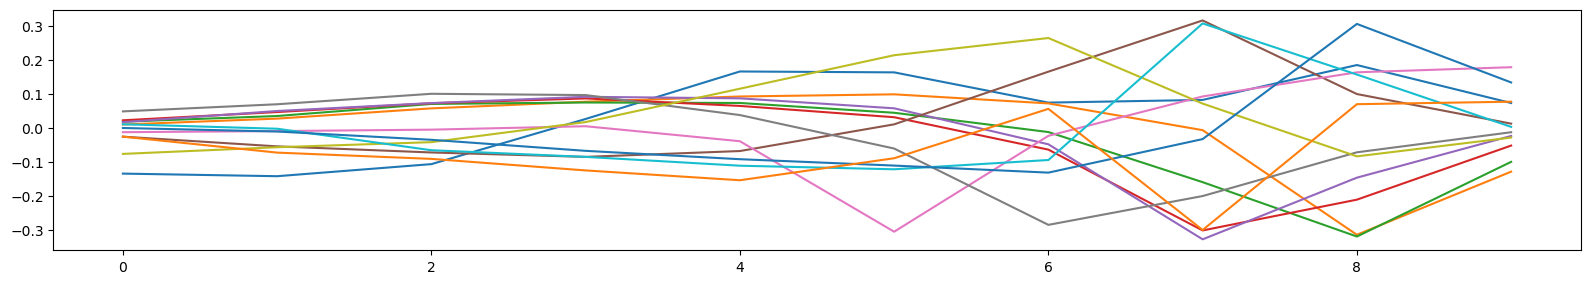

In [130]:
ss()
plt.plot(filters_12[fws[0]//2-1,fws[0]//2-1,:,:])
plt.show()

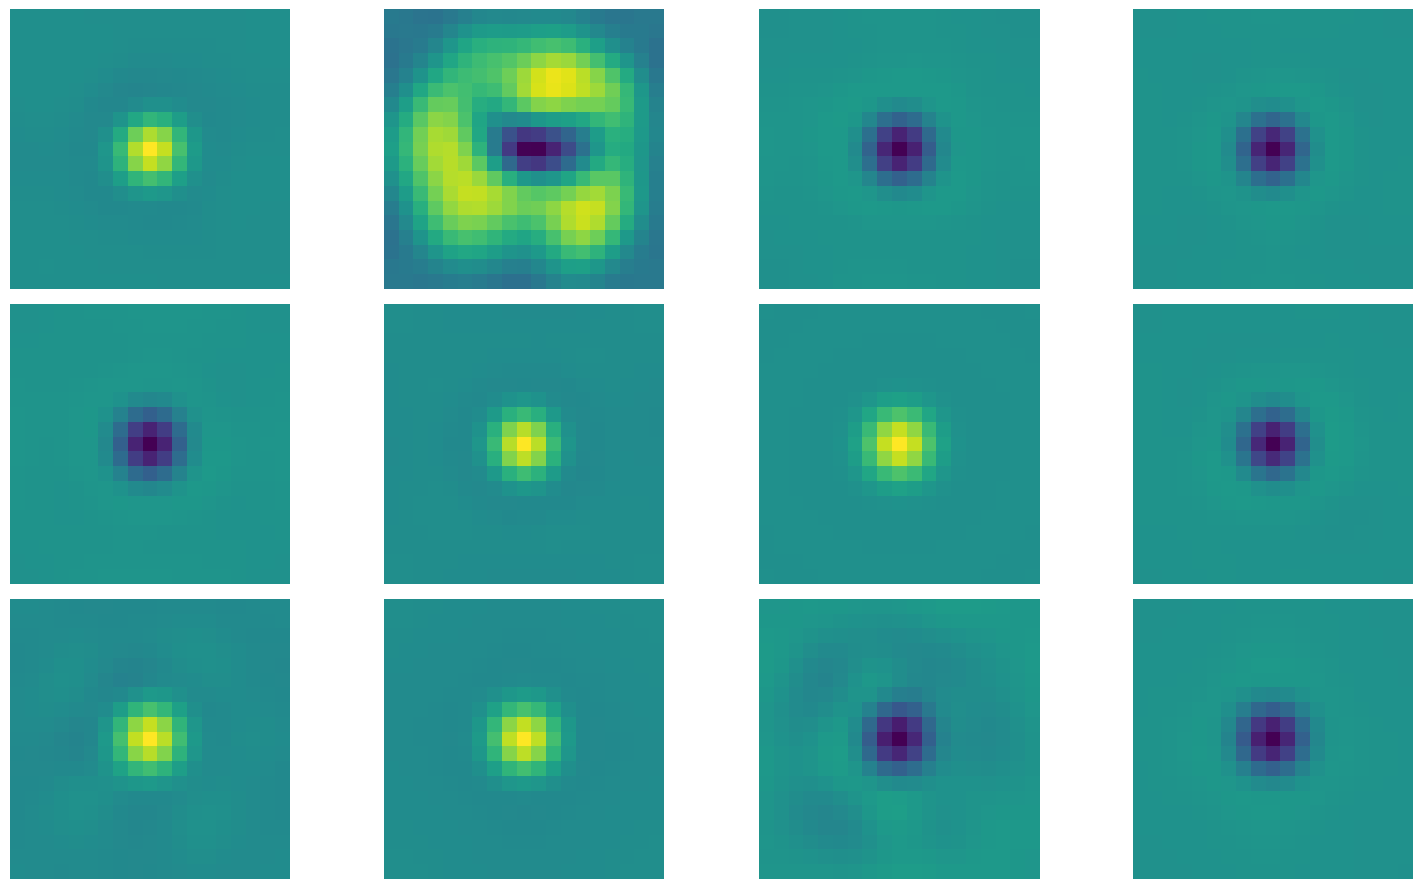

In [134]:
ss(3,4)
for i in range(12):
    plt.subplot(3,4,i+1)
    imagesc(filters_12[:,:,-3,i], balanced=True)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Compare Log-Likelihood

In [16]:
model_order_by_LL = {}
for i in range(len(num_LGN_units)):
    LL_avg_array = np.zeros(num_repeat)
    for k in range(num_repeat):
        LL_avg_array[k] = np.mean(LL_dict[str(num_LGN_units[i])+' LGN Units '+str(k)])
    model_order_by_LL[str(num_LGN_units[i])+' LGN Units'] = np.argsort(LL_avg_array)

In [17]:
model_order_by_LL.keys()

dict_keys(['1 LGN Units', '2 LGN Units', '3 LGN Units', '4 LGN Units'])

In [23]:
top_10_model_LL = {}
for i in range(len(num_LGN_units)):
    chosen_models = list(model_order_by_LL[str(num_LGN_units[i])+' LGN Units'][-10:])
    LL_array = np.zeros((10,NC))
    for j in range(len(chosen_models)):
        k = chosen_models[j]
        LL_array[j,:] = LL_dict[str(num_LGN_units[i])+' LGN Units '+str(k)]
    top_10_model_LL[str(num_LGN_units[i])+' LGN Units'] = LL_array

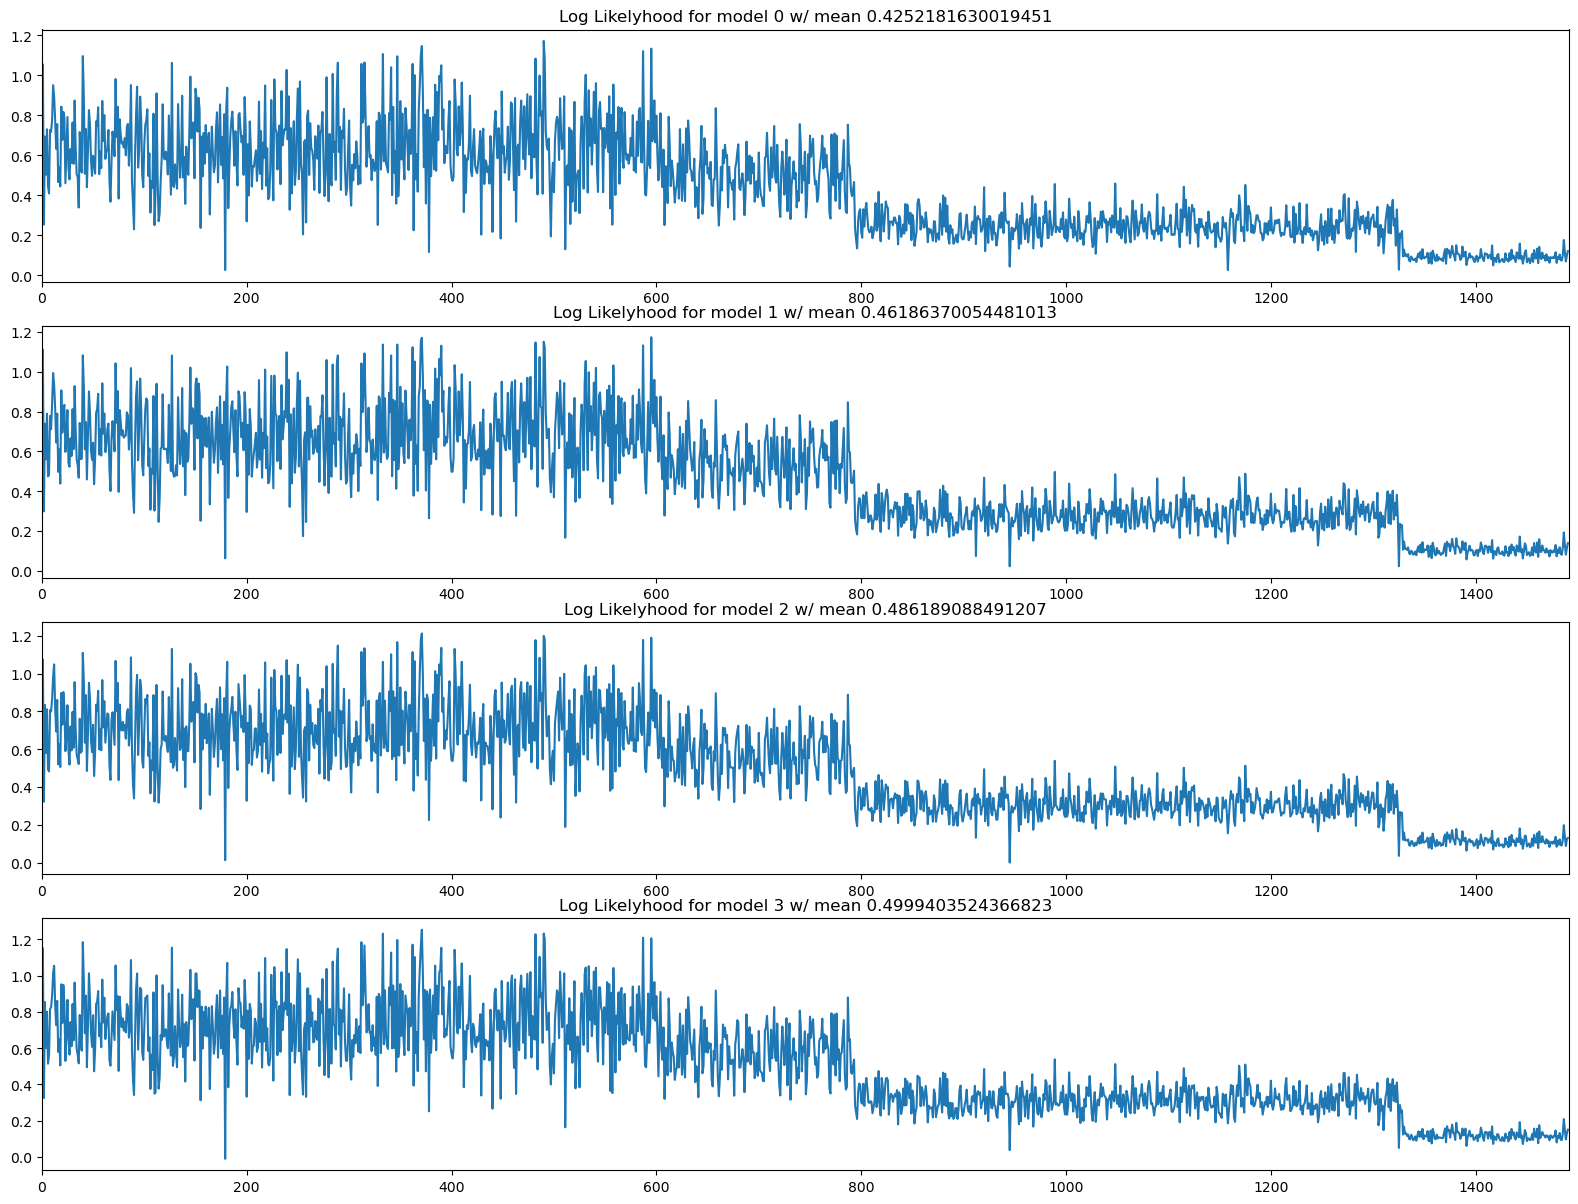

In [26]:
ss(4,1)
for i in range(len(num_LGN_units)):
    LL_array = top_10_model_LL[str(num_LGN_units[i])+' LGN Units']
    plt.subplot(4,1,i+1)
    plt.plot(np.mean(LL_array, axis=0))
    plt.title('Log Likelyhood for model '+str(i)+' w/ mean '+str(np.mean(LL_array)))
    plt.xlim([0,NC])
plt.show()

(0.35, 0.5)

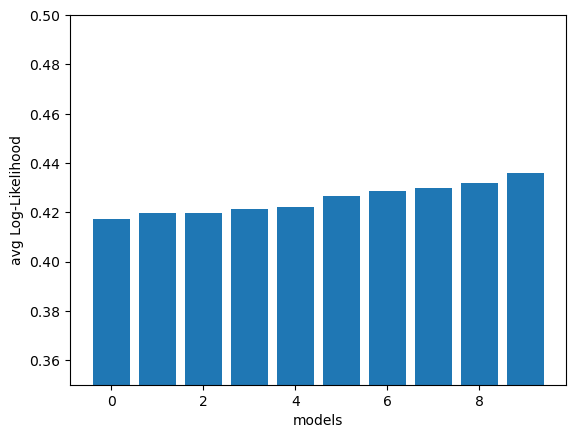

In [103]:
LL_array = top_10_model_LL[str(num_LGN_units[0])+' LGN Units']
plt.bar(np.arange(0,10,1),np.mean(LL_array, axis=1))
plt.xlabel('models')
plt.ylabel('avg Log-Likelihood')
plt.ylim([0.35,0.5])

Text(0, 0.5, 'Log-Likelihood')

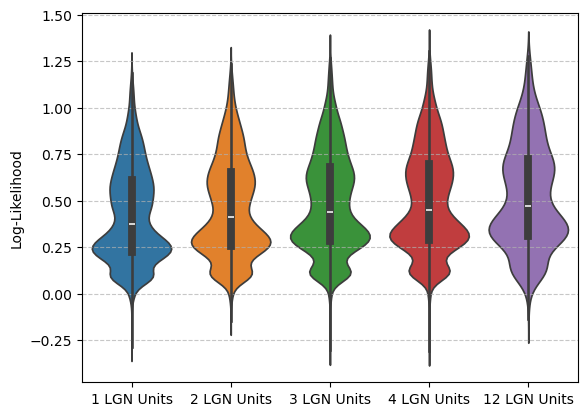

In [127]:
LL_to_plot = [] 
for i in range(len(num_LGN_units)):
    LL_to_plot.append(list(top_10_model_LL[str(num_LGN_units[i])+' LGN Units'].reshape(10*NC)))
LL_to_plot.append(list(LL_12))
labels = list(top_10_model_LL.keys())
sns.violinplot(data=LL_to_plot)
plt.xticks(ticks=range(len(labels)+1), labels=labels+['12 LGN Units'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel('Log-Likelihood')

In [70]:
for i in range(len(num_LGN_units)):
    print(np.mean(LL_to_plot[i]))

0.4252181630019451
0.46186370054481013
0.486189088491207
0.4999403524366823


Text(0.5, 1.0, 'Layer 2/3 Inh')

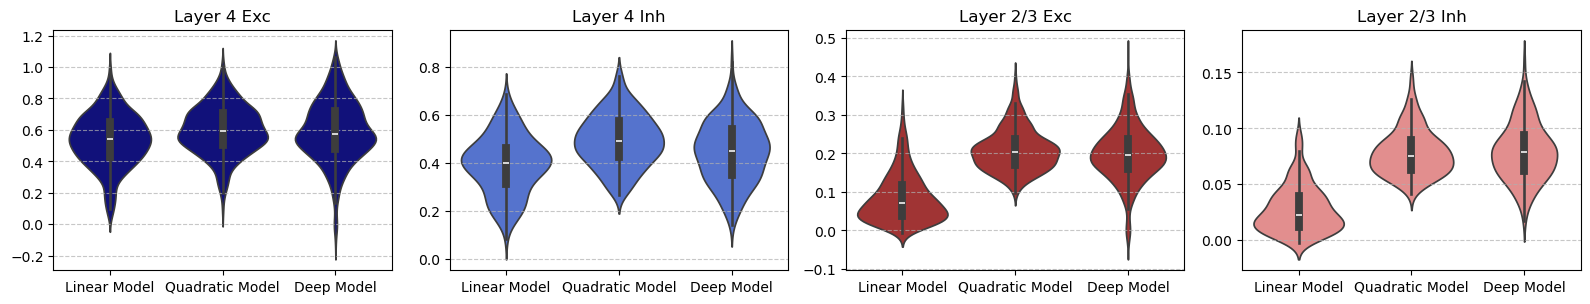

In [38]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[0])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

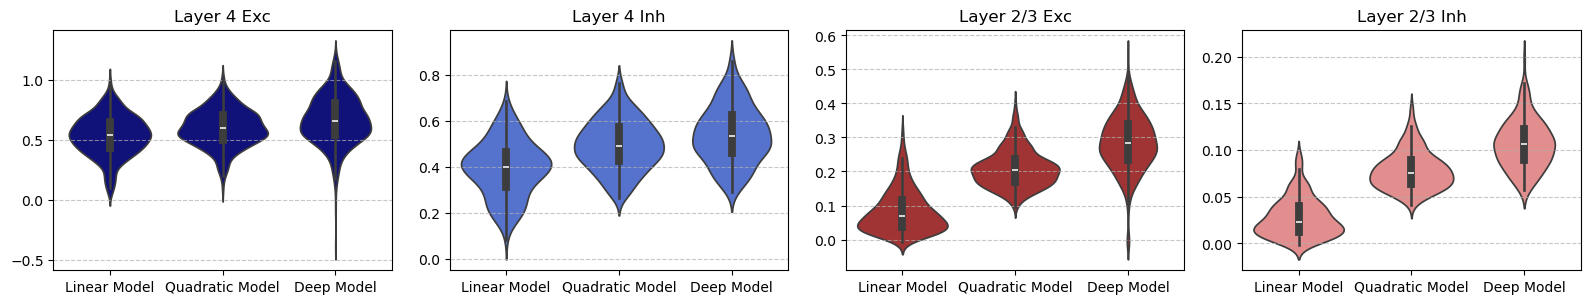

In [39]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[1])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

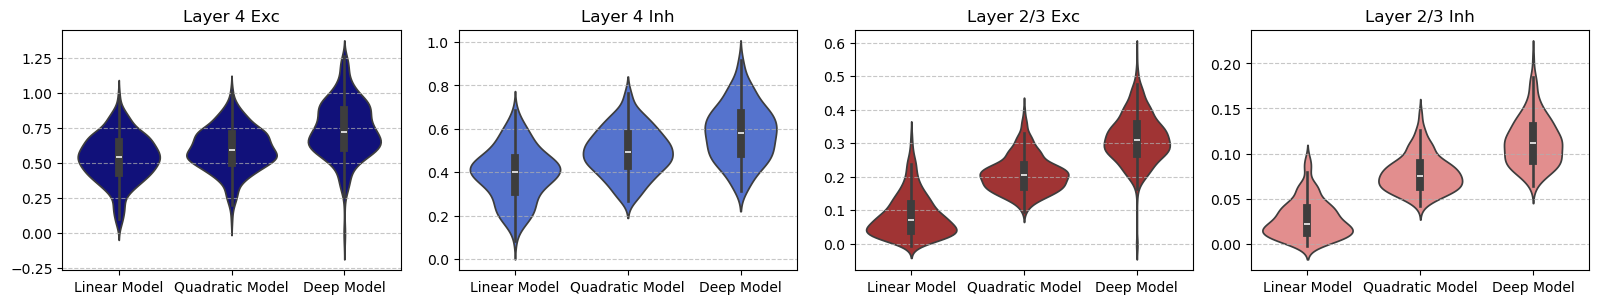

In [40]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[2])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

Text(0.5, 1.0, 'Layer 2/3 Inh')

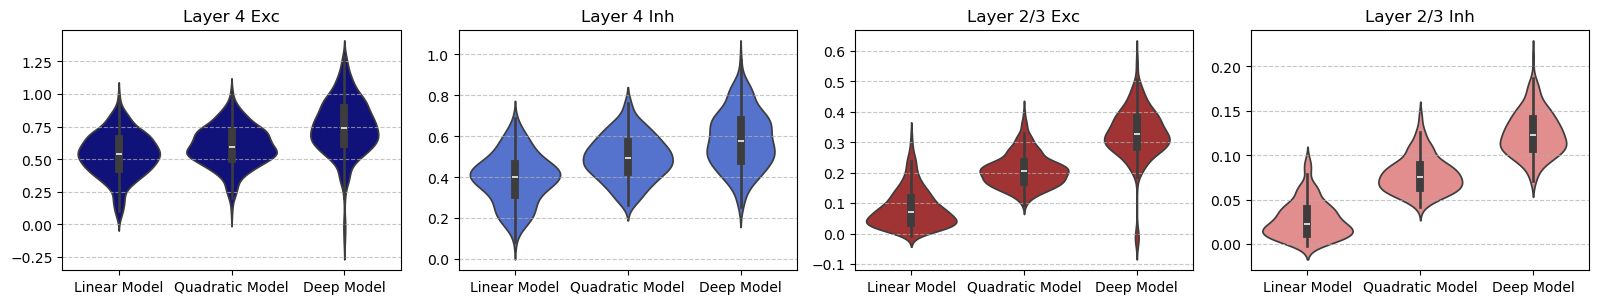

In [41]:
plt.rcParams.update({'font.size': 10})
LL = LL_dict[str(num_LGN_units[3])+' LGN Units']
colors = ['darkblue', 'royalblue', 'firebrick', 'lightcoral']
ss(1,4)
plt.subplot(1,4,1)
LL_to_plot = [GLM_LL['V1_Exc_L4'], GQM_LL['V1_Exc_L4'], LL[L4_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[0])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Exc')

plt.subplot(1,4,2)
LL_to_plot = [GLM_LL['V1_Inh_L4'], GQM_LL['V1_Inh_L4'], LL[L4_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[1])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 4 Inh')

plt.subplot(1,4,3)
LL_to_plot = [GLM_LL['V1_Exc_L2/3'], GQM_LL['V1_Exc_L2/3'], LL[L23_exc_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[2])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Exc')

plt.subplot(1,4,4)
LL_to_plot = [GLM_LL['V1_Inh_L2/3'], GQM_LL['V1_Inh_L2/3'], LL[L23_inh_idx]]
labels = ['Linear Model', 'Quadratic Model', 'Deep Model']
sns.violinplot(data=LL_to_plot, color=colors[3])
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Layer 2/3 Inh')

## Compare Filters

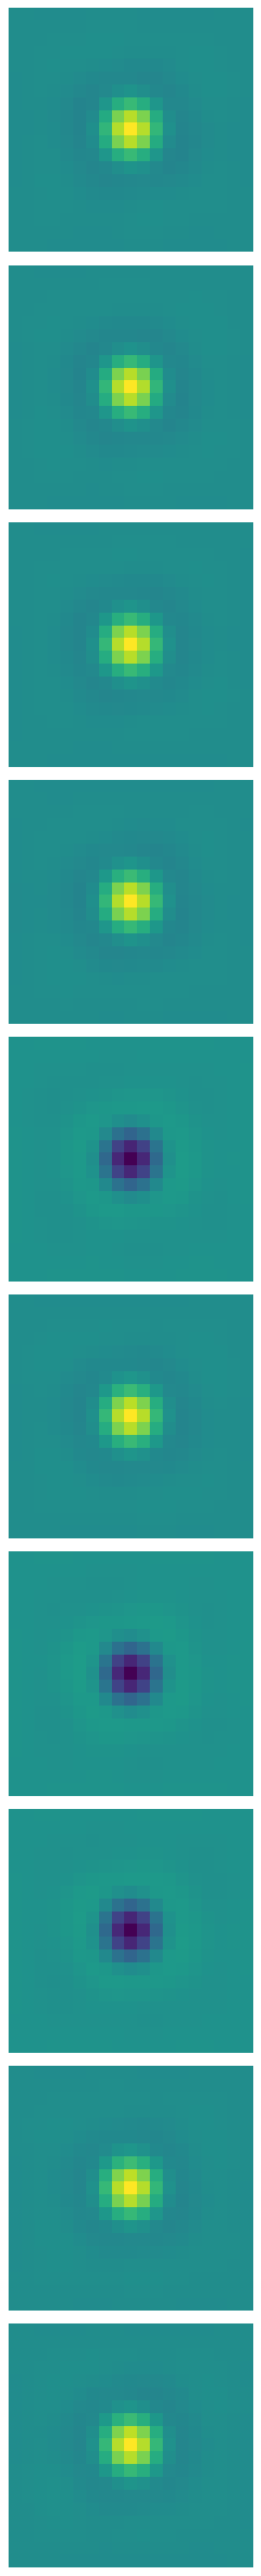

In [37]:
model1_top_10 = model_order_by_LL[str(num_LGN_units[0])+' LGN Units'][-10:]
ss(10,1)
for j in range(10):
    cnn = models[str(num_LGN_units[0])+' LGN Units '+str(model1_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)[:,:,-2,0]
    plt.subplot(10,1,j+1)
    imagesc(filters, balanced=True)
    plt.axis('off')
plt.tight_layout()
plt.show()

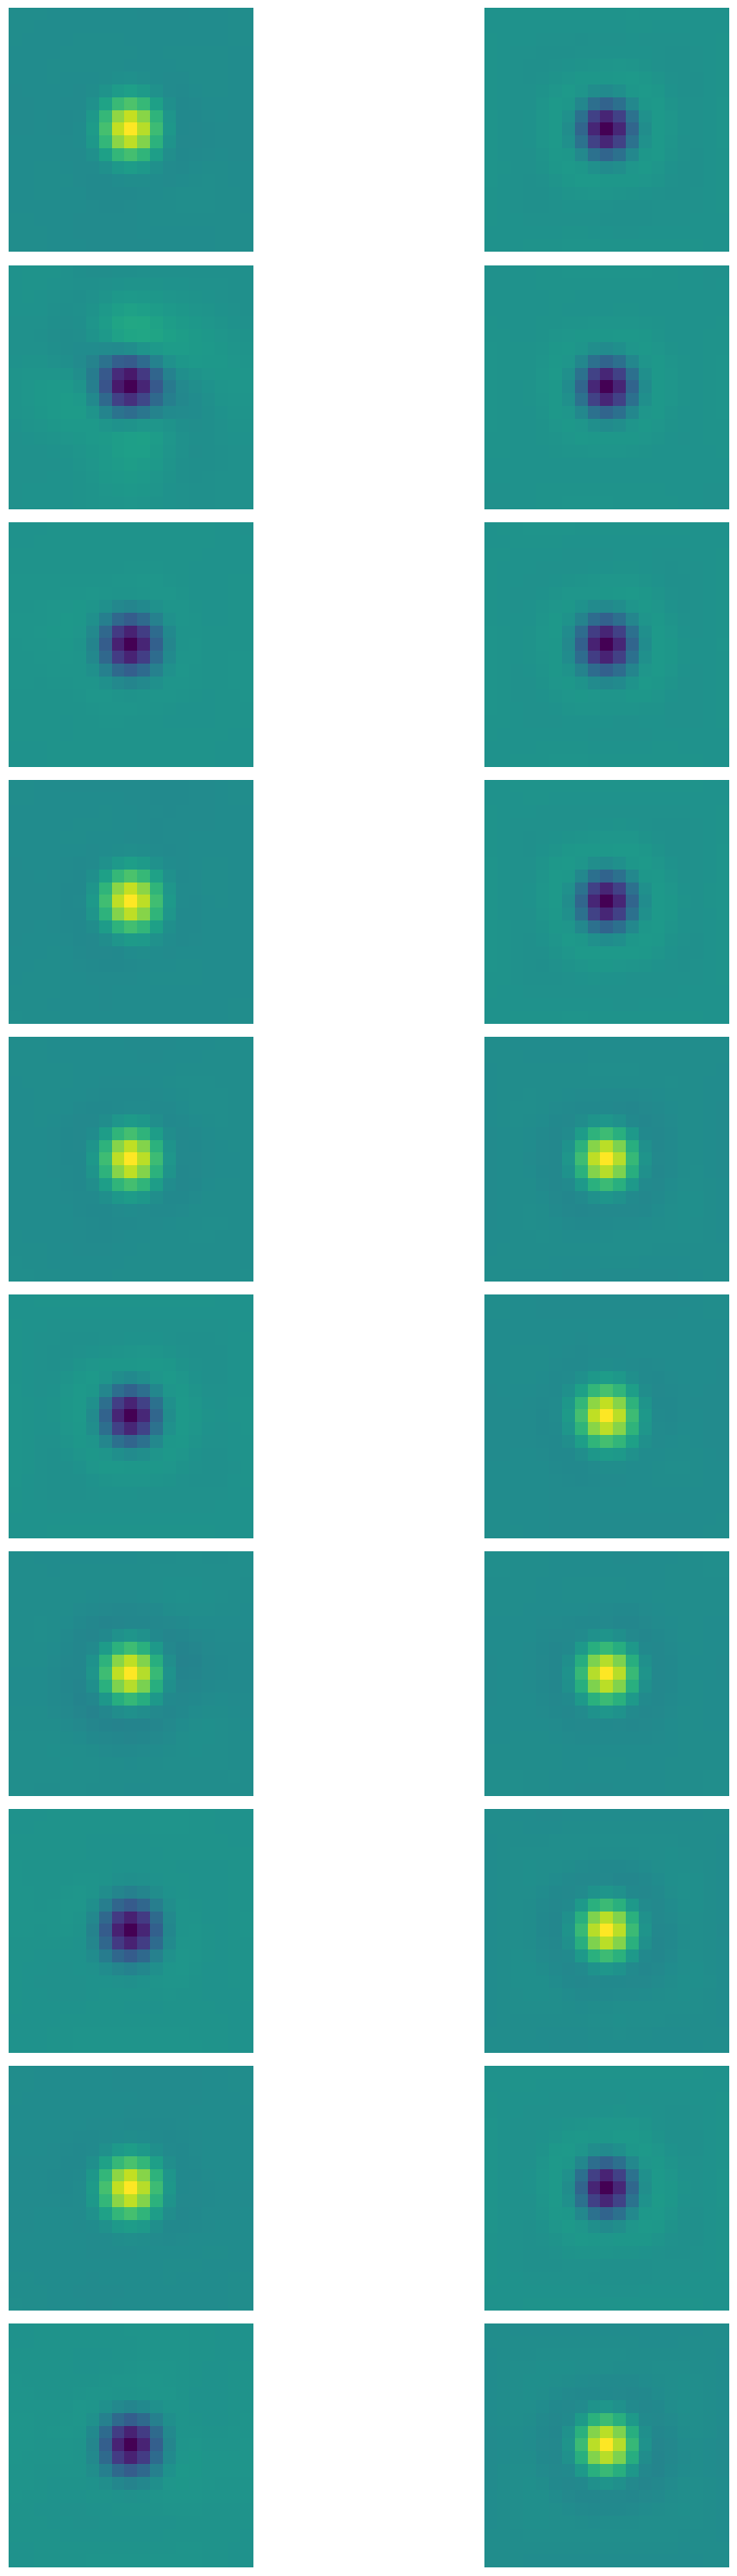

In [42]:
model2_top_10 = model_order_by_LL[str(num_LGN_units[1])+' LGN Units'][-10:]
ss(10,2)
k = 1
for j in range(10):
    cnn = models[str(num_LGN_units[1])+' LGN Units '+str(model2_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)[:,:,-2,:]
    plt.subplot(10,2,k)
    imagesc(filters[:,:,0], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,2,k)
    imagesc(filters[:,:,1], balanced=True)
    plt.axis('off')
    k += 1
    
plt.tight_layout()
plt.show()

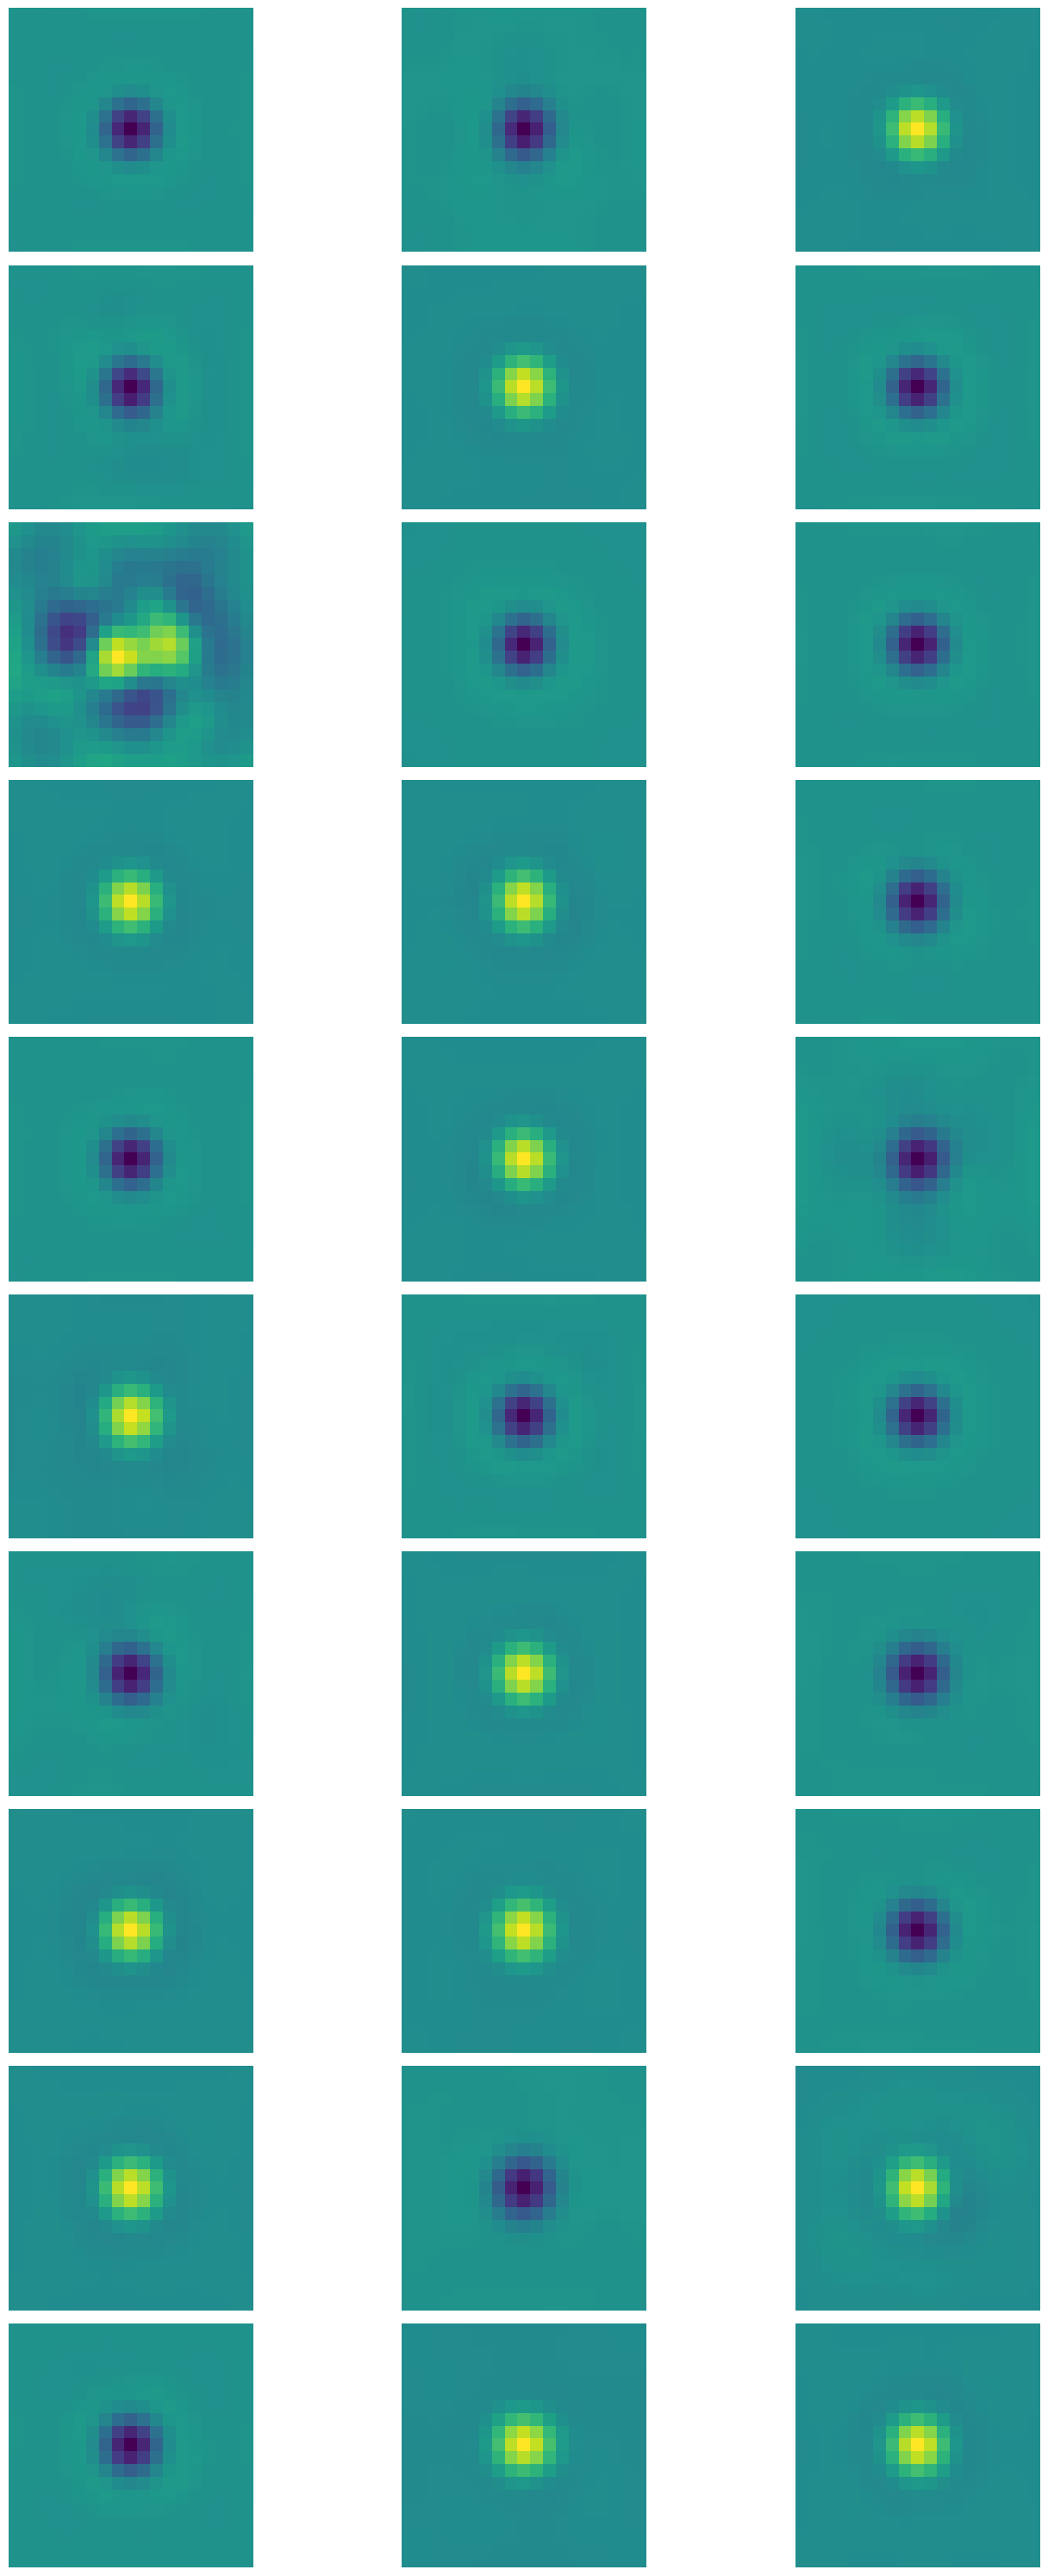

In [43]:
model3_top_10 = model_order_by_LL[str(num_LGN_units[2])+' LGN Units'][-10:]
ss(10,3)
k = 1
for j in range(10):
    cnn = models[str(num_LGN_units[2])+' LGN Units '+str(model3_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)[:,:,-2,:]
    plt.subplot(10,3,k)
    imagesc(filters[:,:,0], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,3,k)
    imagesc(filters[:,:,1], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,3,k)
    imagesc(filters[:,:,2], balanced=True)
    plt.axis('off')
    k += 1
    
plt.tight_layout()
plt.show()

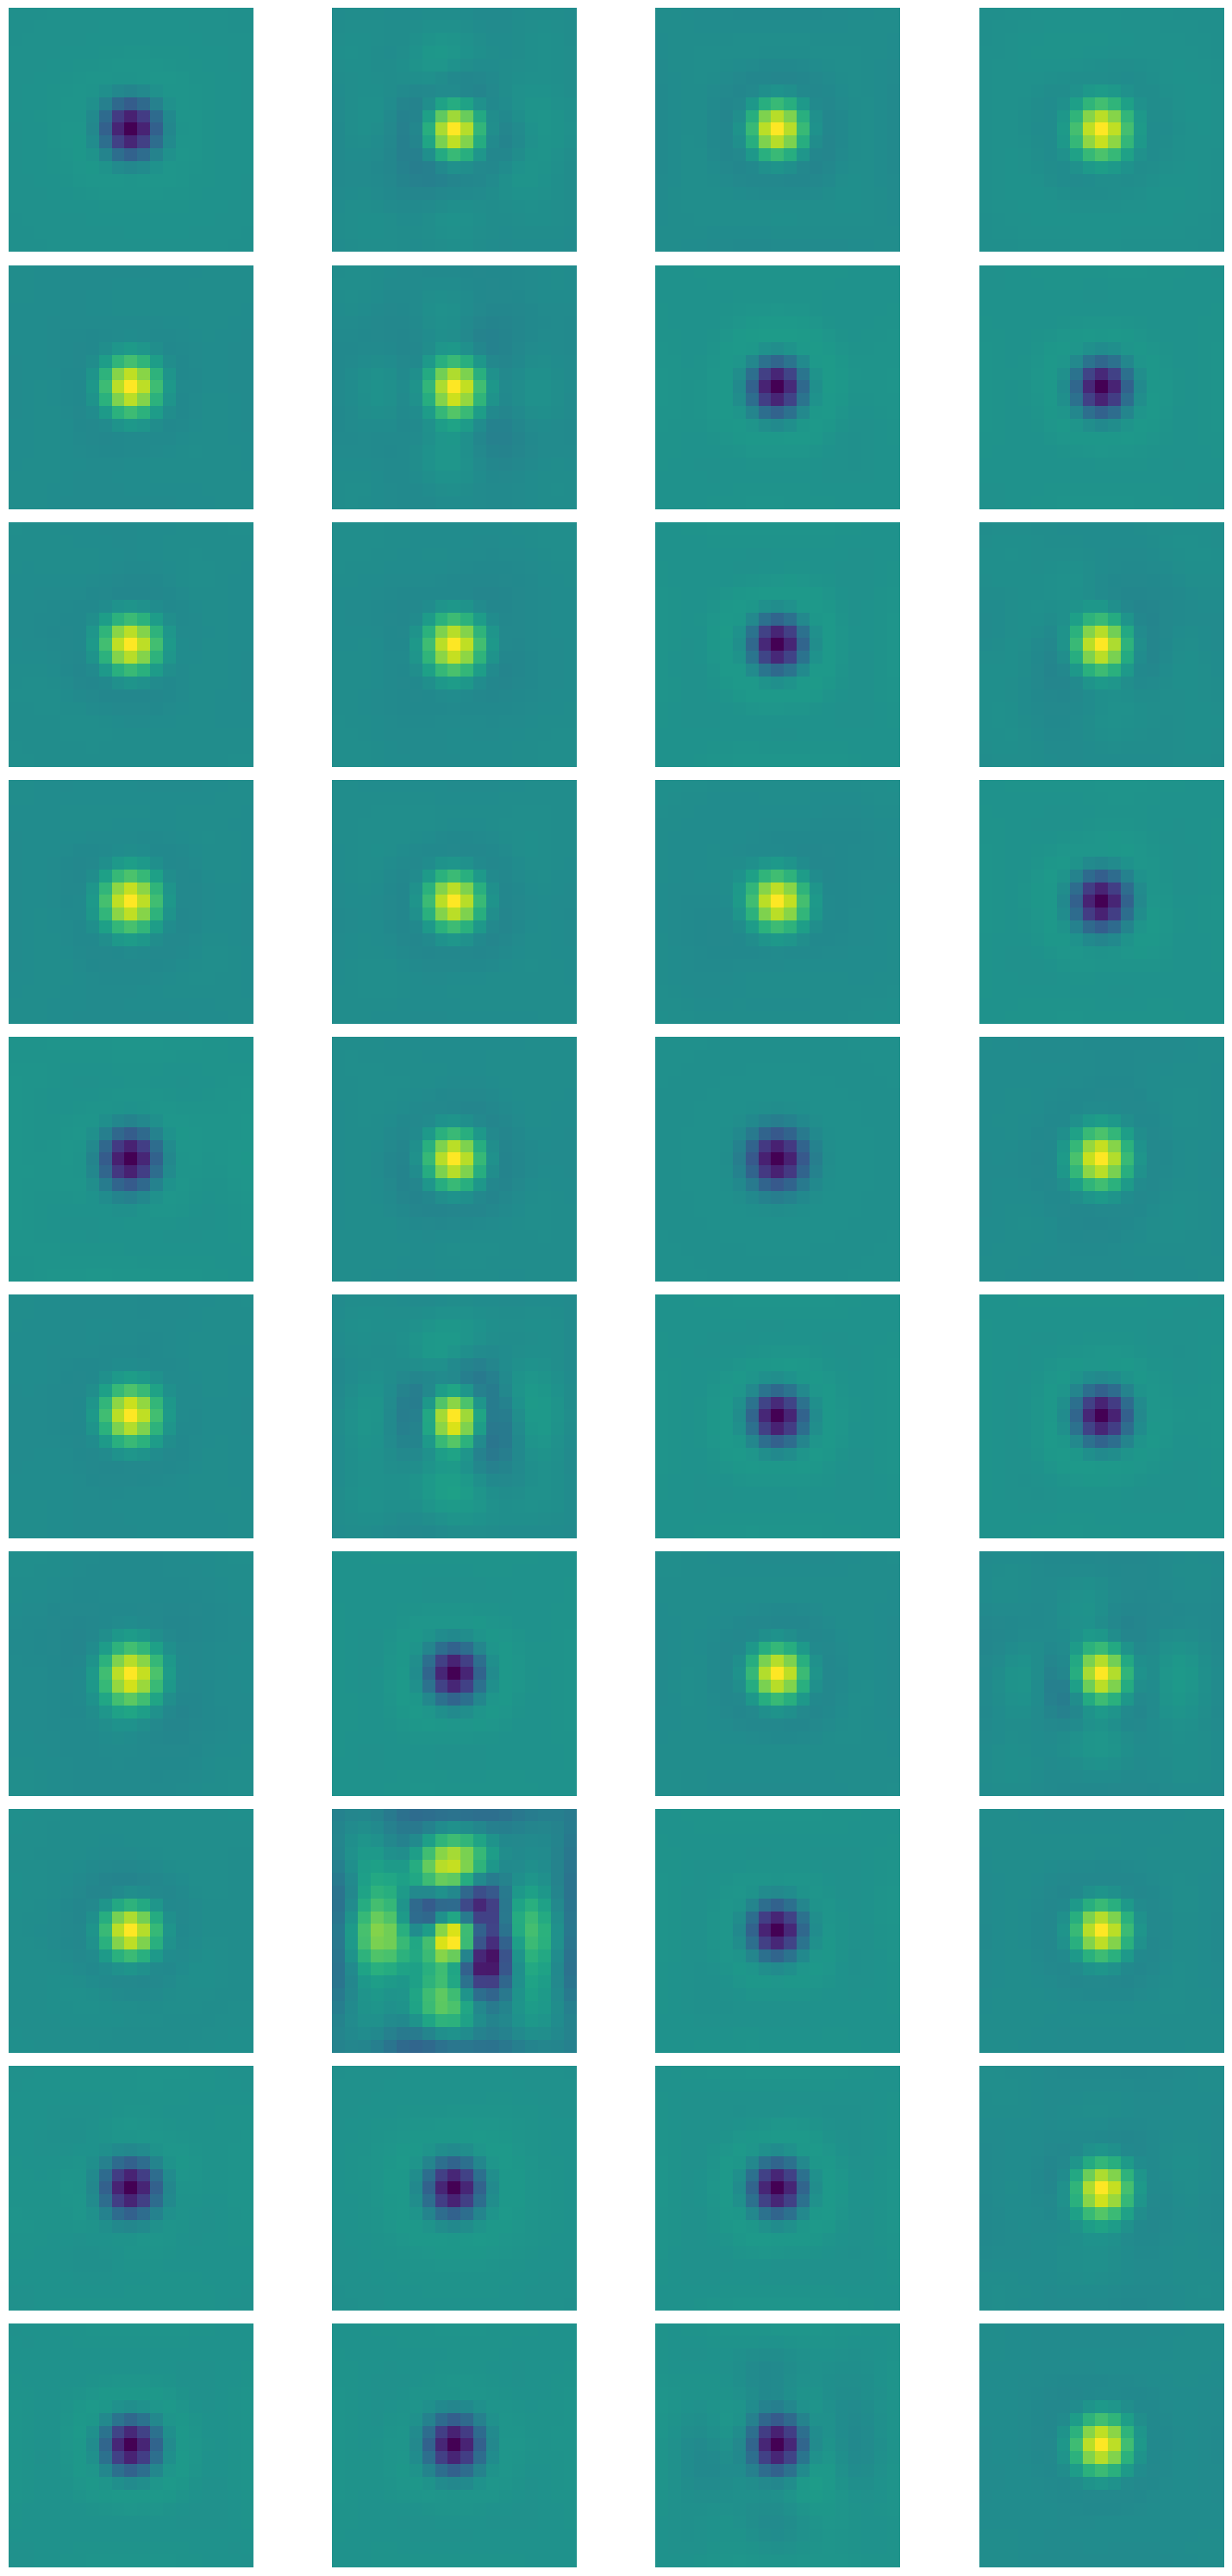

In [44]:
model4_top_10 = model_order_by_LL[str(num_LGN_units[3])+' LGN Units'][-10:]
ss(10,4)
k = 1
for j in range(10):
    cnn = models[str(num_LGN_units[3])+' LGN Units '+str(model4_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)[:,:,-2,:]
    plt.subplot(10,4,k)
    imagesc(filters[:,:,0], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,4,k)
    imagesc(filters[:,:,1], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,4,k)
    imagesc(filters[:,:,2], balanced=True)
    plt.axis('off')
    k += 1

    plt.subplot(10,4,k)
    imagesc(filters[:,:,3], balanced=True)
    plt.axis('off')
    k += 1
    
plt.tight_layout()
plt.show()

## Within Model Temporal Profile

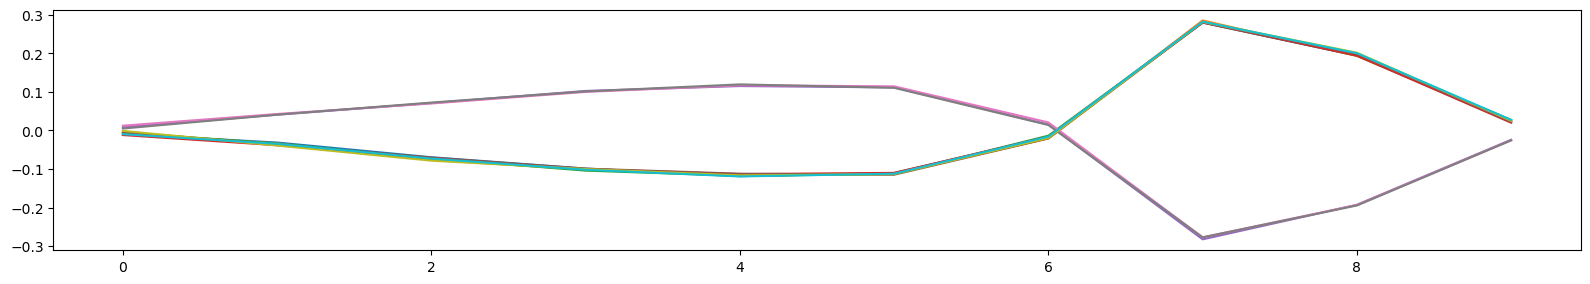

In [56]:
ss()
for j in range(10):
    cnn = models[str(num_LGN_units[0])+' LGN Units '+str(model1_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,:])
plt.show()

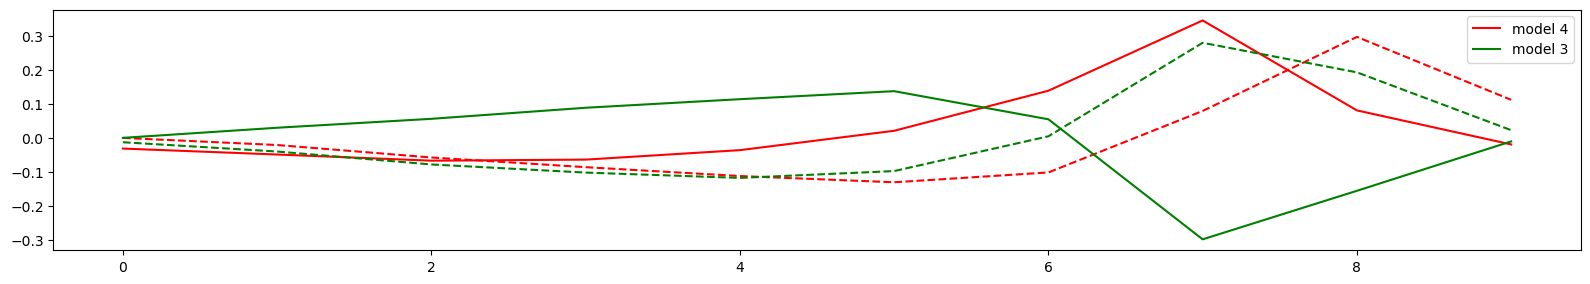

In [106]:
ss()
col_list = ['red','blue','green','red']
for j in [-4,-3]:
    cnn = models[str(num_LGN_units[1])+' LGN Units '+str(model2_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,0],color=col_list[int(j*-1-1)], label='model '+str(j*-1))
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,1],color=col_list[int(j*-1-1)],linestyle="--")
plt.legend()
plt.show()

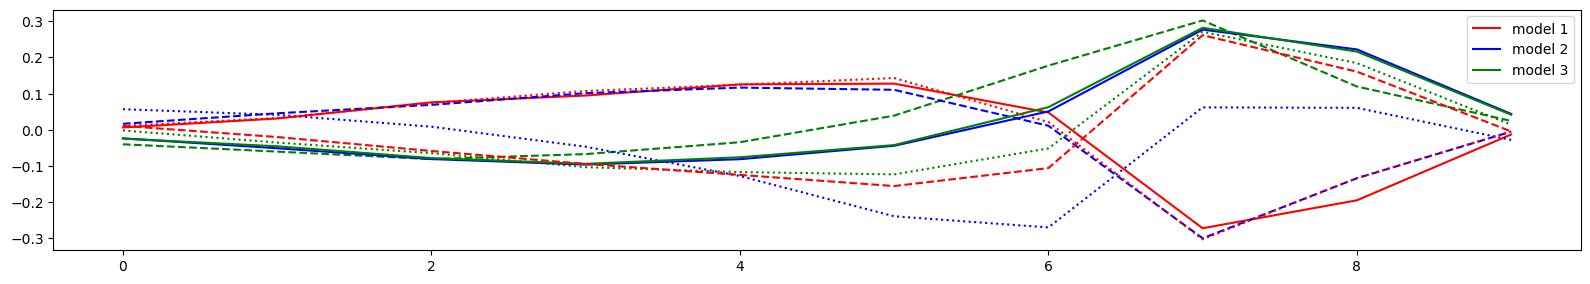

In [74]:
ss()
col_list = ['red','blue','green']
for j in [-1,-2,-3]:
    cnn = models[str(num_LGN_units[2])+' LGN Units '+str(model3_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,0],color=col_list[(j*-1)-1], label='model '+str(-1*j))
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,1],color=col_list[j],linestyle="--")
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,2],color=col_list[j],linestyle=":")
plt.legend()
plt.show()

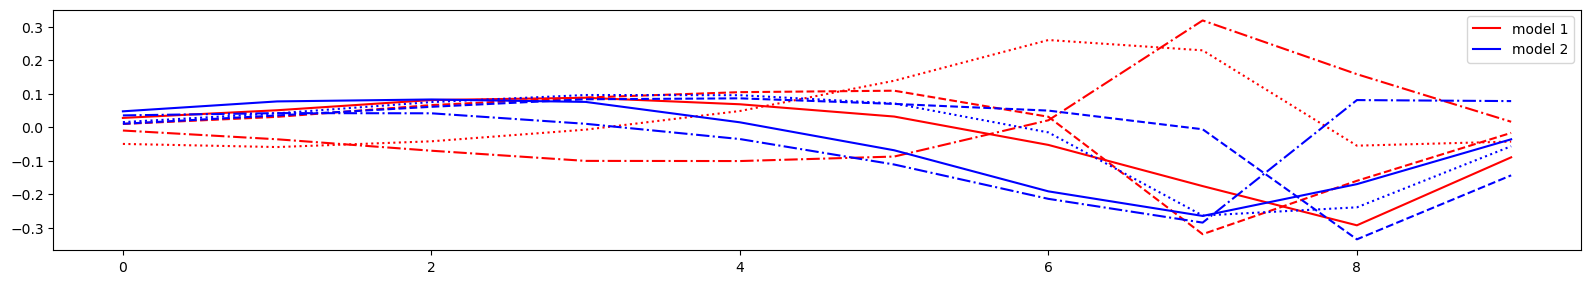

In [75]:
ss()
col_list = ['red','blue']
for j in [-1,-2]:
    cnn = models[str(num_LGN_units[3])+' LGN Units '+str(model4_top_10[j])]
    filters = cnn.get_weights(ffnet_target=0,layer_target=0)
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,0],color=col_list[(-1*j)-1],label='model '+str(-1*j))
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,1],color=col_list[(-1*j)-1],linestyle="--")
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,2],color=col_list[(-1*j)-1],linestyle=":")
    plt.plot(filters[fws[0]//2-1,fws[0]//2-1,:,3],color=col_list[(-1*j)-1],linestyle="-.")
plt.legend()
plt.show()

## Across Model Temporal Profile

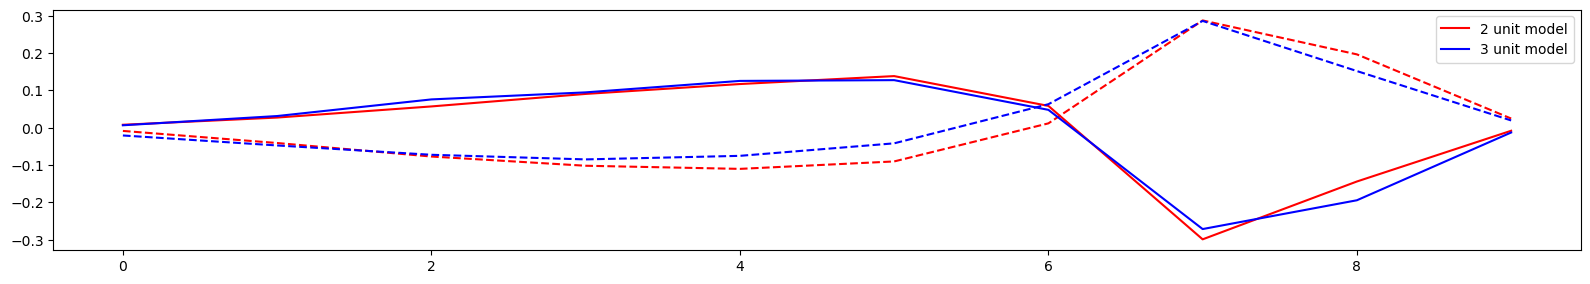

In [79]:
ss()
cnn1 = models[str(num_LGN_units[1])+' LGN Units '+str(model2_top_10[-1])]
filters1 = cnn1.get_weights(ffnet_target=0,layer_target=0)
plt.plot(filters1[fws[0]//2-1,fws[0]//2-1,:,0],color='red',label='2 unit model')
plt.plot(filters1[fws[0]//2-1,fws[0]//2-1,:,1],color='red',linestyle="--")

cnn2 = models[str(num_LGN_units[2])+' LGN Units '+str(model3_top_10[-1])]
filters2 = cnn2.get_weights(ffnet_target=0,layer_target=0)
plt.plot(filters2[fws[0]//2-1,fws[0]//2-1,:,0],color='blue',label='3 unit model')
#plt.plot(filters2[fws[0]//2-1,fws[0]//2-1,:,1],color='blue',linestyle="--")
#plt.plot(filters2[fws[0]//2-1,fws[0]//2-1,:,2],color='blue',linestyle=":")
plt.plot(np.mean(filters2[fws[0]//2-1,fws[0]//2-1,:,1:],axis=1),color='blue',linestyle="--")
plt.legend()
plt.show()

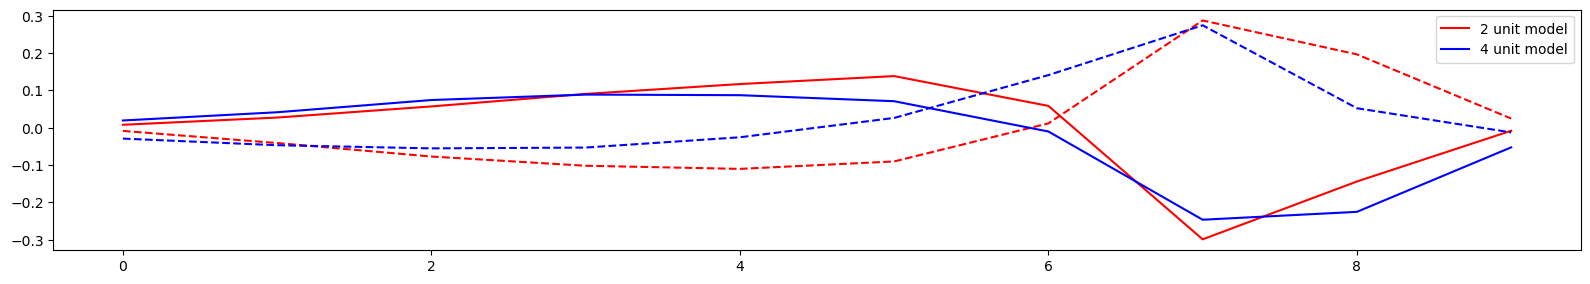

In [84]:
ss()
cnn1 = models[str(num_LGN_units[1])+' LGN Units '+str(model2_top_10[-1])]
filters1 = cnn1.get_weights(ffnet_target=0,layer_target=0)
plt.plot(filters1[fws[0]//2-1,fws[0]//2-1,:,0],color='red',label='2 unit model')
plt.plot(filters1[fws[0]//2-1,fws[0]//2-1,:,1],color='red',linestyle="--")

cnn3 = models[str(num_LGN_units[3])+' LGN Units '+str(model4_top_10[-1])]
filters3 = cnn3.get_weights(ffnet_target=0,layer_target=0)
#plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,0],color='blue',label='4 unit model')
#plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,1],color='blue',linestyle="--")
#plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,2],color='blue',linestyle=":")
#plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,3],color='blue',linestyle="-.")
plt.plot(np.mean(filters3[fws[0]//2-1,fws[0]//2-1,:,:2],axis=1),color='blue',label='4 unit model')
plt.plot(np.mean(filters3[fws[0]//2-1,fws[0]//2-1,:,2:],axis=1),color='blue',linestyle="--")
plt.legend()
plt.show()

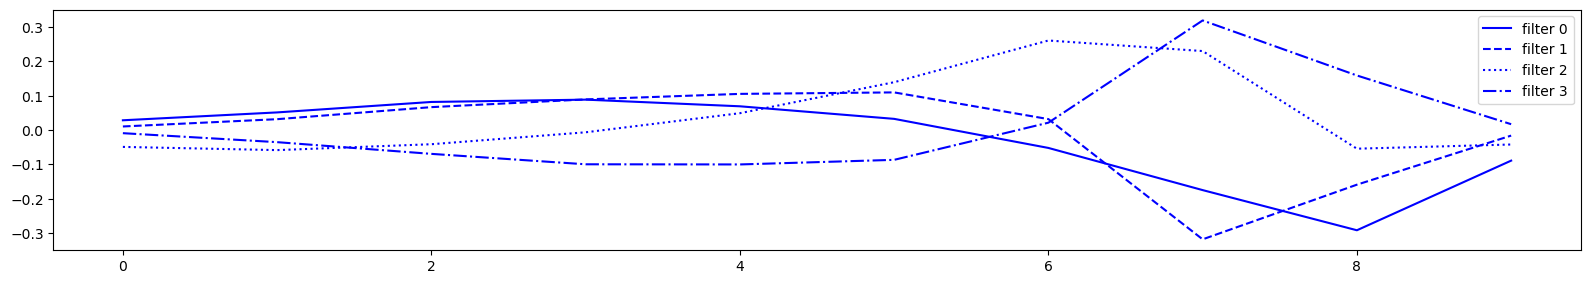

In [113]:
ss()
plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,0],color='blue',label='filter 0')
plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,1],color='blue',linestyle="--",label='filter 1')
plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,2],color='blue',linestyle=":",label='filter 2')
plt.plot(filters3[fws[0]//2-1,fws[0]//2-1,:,3],color='blue',linestyle="-.",label='filter 3')
plt.legend()
plt.show()

## Next Layer Weight Distribution

In [226]:
next_layer_weights = LGN_12_cnn.get_weights(ffnet_target=0,layer_target=1)
next_layer_weights.shape

(12, 19, 19, 24)

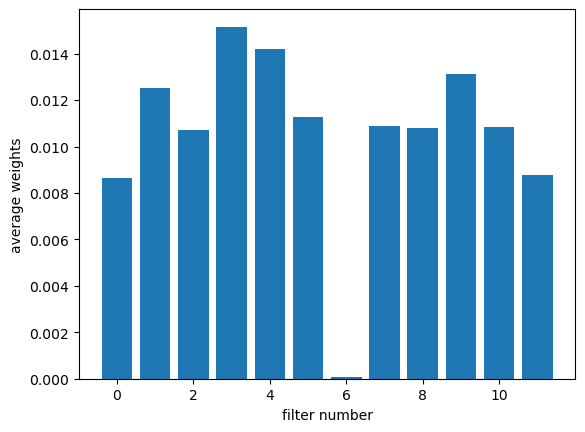

In [227]:
plt.bar(np.arange(0,12,1),np.mean(np.abs(next_layer_weights),axis=(1,2,3)))
plt.xlabel('filter number')
plt.ylabel('average weights')
plt.show()

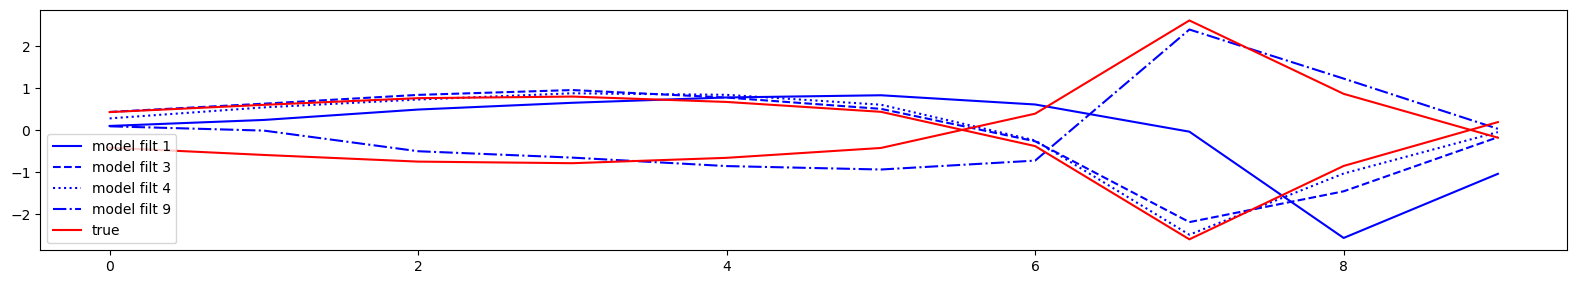

In [239]:
high_weight_idx = list(np.where(np.mean(np.abs(next_layer_weights),axis=(1,2,3))>0.012)[0])
line_list = ['-', '--', ':', '-.']
ss()
for j in range(len(high_weight_idx)):
    i = high_weight_idx[j]
    plt.plot((pred_temp[:,i]-np.mean(pred_temp[:,i]))/np.std(pred_temp[:,i]), label='model filt '+str(i), color='blue', linestyle=line_list[j])

plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

## Simulation Temporal Profile

In [14]:
A_c = 1.0
A_s = 0.032473
s_c = 0.103253
s_s = 0.461558
K1 = 0.979516
K2 = 0.202640
c1 = 1.095625
c2 = 0.274145
t1 = -83.501129
t2 = -135.830829
n1 = 124.130728
n2 = 64.731311
td = 6.000000

def r(X,T):
    return f_c(X)*g_c(T) + f_s(X)*g_s(T)
def f_c(X):
    aux = ((X-x_c)**2)/s_c
    return A_c * np.exp(-1*aux)
def g_c(T):
    aux1 = ((c1*(T-t1))**n1 * np.exp(-1*c1*(T-t1))) / (n1**n1 * np.exp(-1*n1))
    aux2 = ((c2*(T-t2))**n2 * np.exp(-1*c2*(T-t2))) / (n2**n2 * np.exp(-1*n2))
    return K1*aux1 - K2*aux2
def f_s(X):
    aux = ((X-x_s)**2)/s_s
    return A_s * np.exp(-1*aux)
def g_s(T):
    return g_c(T-td)

In [15]:
T = np.arange(0,160,7.9)
true_temp = g_c(T)
true_temp.shape
#avg_temp = np.zeros(10)
#for i in range(1,10):
#    avg_temp[i] = np.mean(true_temp[(i*16)-16:(i*16)])
#print(avg_temp.shape)

(21,)

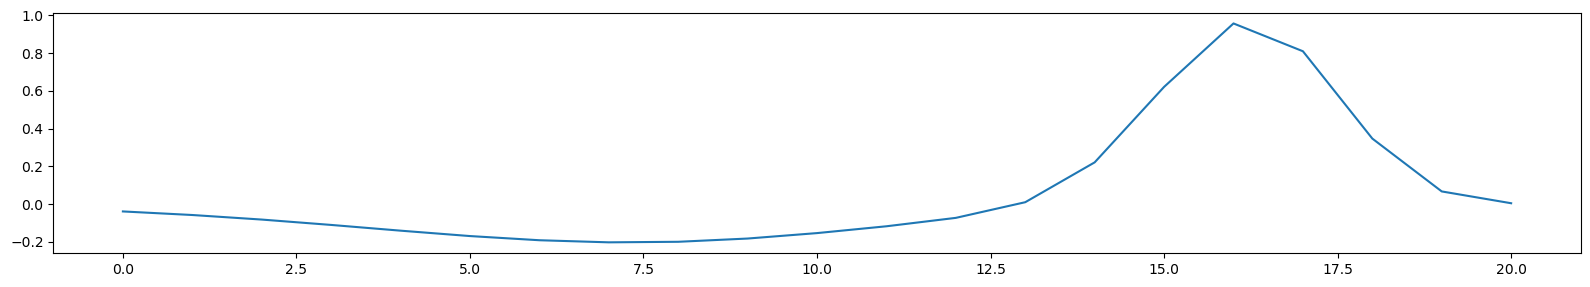

In [16]:
ss()
plt.plot(true_temp[::-1])

### 1 LGN Unit

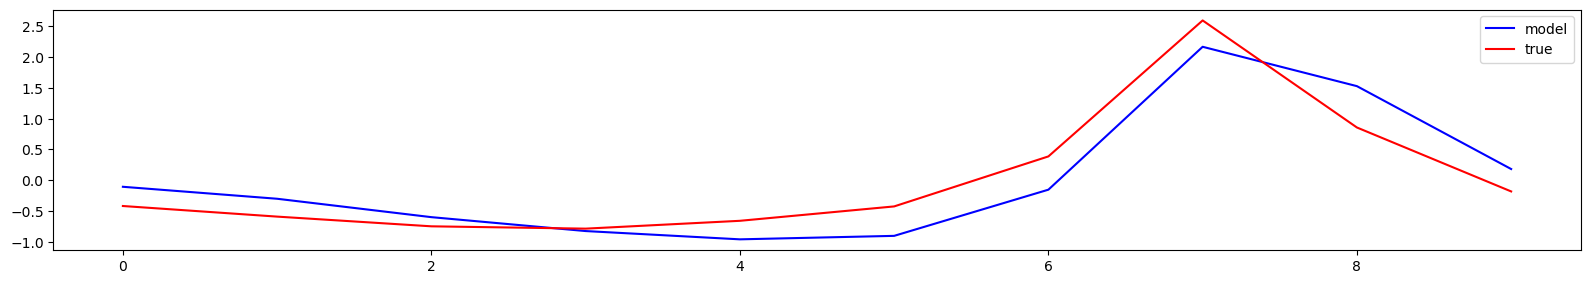

In [216]:
cnn = models[str(num_LGN_units[0])+' LGN Units '+str(model1_top_10[-1])]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp-np.mean(pred_temp))/np.std(pred_temp), label='model', color='blue')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true',color='red')
plt.legend()
plt.show()

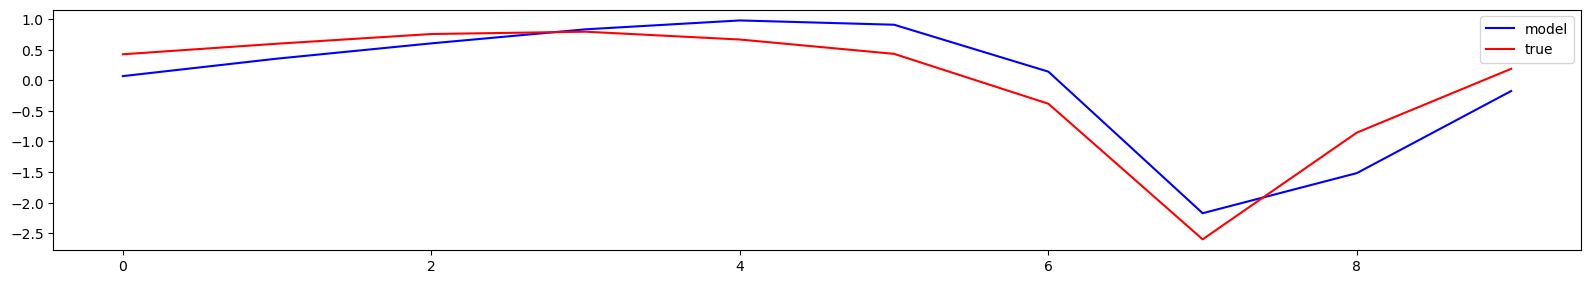

In [217]:
cnn = models[str(num_LGN_units[0])+' LGN Units '+str(model1_top_10[-3])]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp-np.mean(pred_temp))/np.std(pred_temp), label='model', color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true',color='red')
plt.legend()
plt.show()

### 2 LGN Units

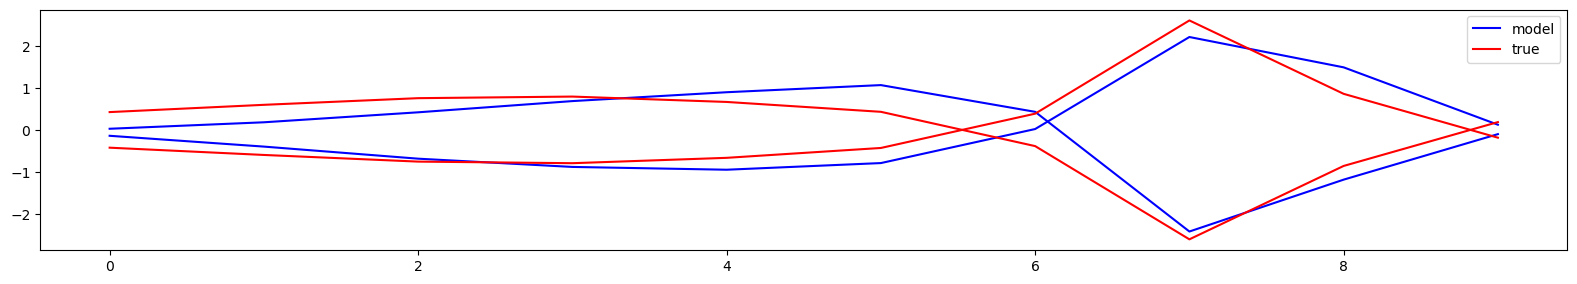

In [208]:
cnn = models[str(num_LGN_units[1])+' LGN Units '+str(model2_top_10[-1])]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp[:,0]-np.mean(pred_temp[:,0]))/np.std(pred_temp[:,0]), label='model', color='blue')
plt.plot((pred_temp[:,1]-np.mean(pred_temp[:,1]))/np.std(pred_temp[:,1]), color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

### 3 LGN Units

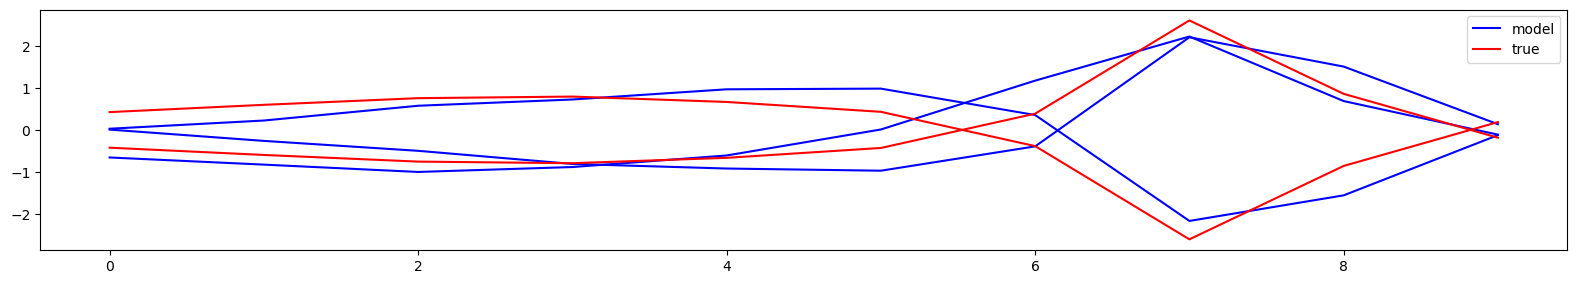

In [210]:
cnn = models[str(num_LGN_units[2])+' LGN Units '+str(model3_top_10[-1])]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp[:,0]-np.mean(pred_temp[:,0]))/np.std(pred_temp[:,0]), label='model', color='blue')
plt.plot((pred_temp[:,1]-np.mean(pred_temp[:,1]))/np.std(pred_temp[:,1]), color='blue')
plt.plot((pred_temp[:,2]-np.mean(pred_temp[:,2]))/np.std(pred_temp[:,2]), color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

### 4 LGN Units

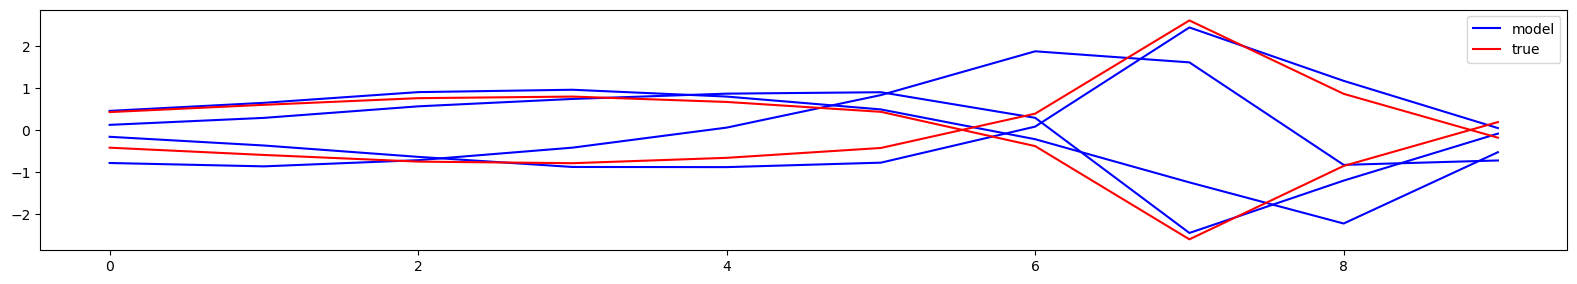

In [214]:
cnn = models[str(num_LGN_units[3])+' LGN Units '+str(model4_top_10[-1])]
filters = cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
plt.plot((pred_temp[:,0]-np.mean(pred_temp[:,0]))/np.std(pred_temp[:,0]), label='model', color='blue')
plt.plot((pred_temp[:,1]-np.mean(pred_temp[:,1]))/np.std(pred_temp[:,1]), color='blue')
plt.plot((pred_temp[:,2]-np.mean(pred_temp[:,2]))/np.std(pred_temp[:,2]), color='blue')
plt.plot((pred_temp[:,3]-np.mean(pred_temp[:,3]))/np.std(pred_temp[:,3]), color='blue')
plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

### 12 LGN Units

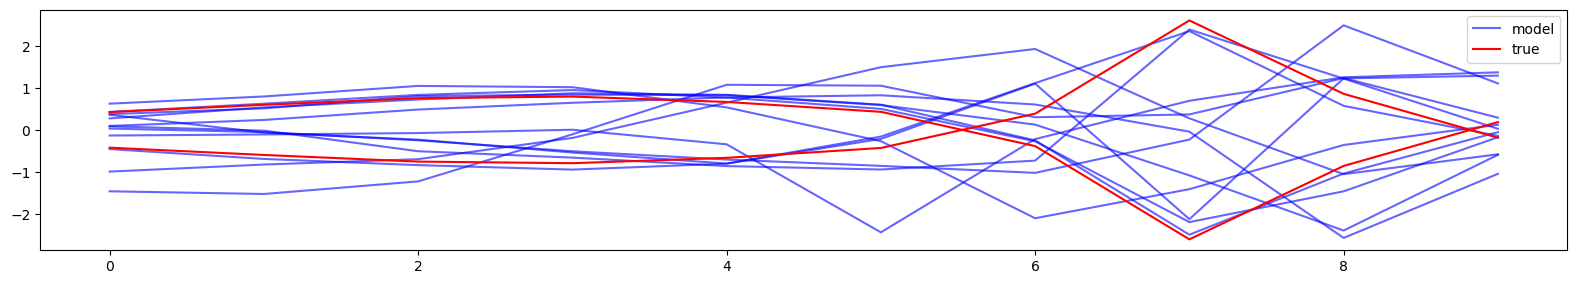

In [225]:
filters = LGN_12_cnn.get_weights(ffnet_target=0,layer_target=0)
pred_temp = filters[fws[0]//2-1,fws[0]//2-1,:,:]
ss()
for i in range(12):
    if i == 0:
        plt.plot((pred_temp[:,i]-np.mean(pred_temp[:,i]))/np.std(pred_temp[:,i]), label='model', color='blue', alpha=0.6)
    else:
        plt.plot((pred_temp[:,i]-np.mean(pred_temp[:,i]))/np.std(pred_temp[:,i]), color='blue', alpha=0.6)

plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

In [232]:
temp_corr = np.zeros(12)
true_p1 = (true_temp[::-1]-np.mean(true_temp))/np.std(true_temp)
true_m1 = -1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp)

for i in range(12):
    corr_p1 = np.corrcoef(pred_temp[:,i],true_p1)[0,1]
    corr_m1 = np.corrcoef(pred_temp[:,i],true_m1)[0,1]
    if corr_p1 > corr_m1:
        temp_corr[i] = corr_p1
    else:
        temp_corr[i] = corr_m1

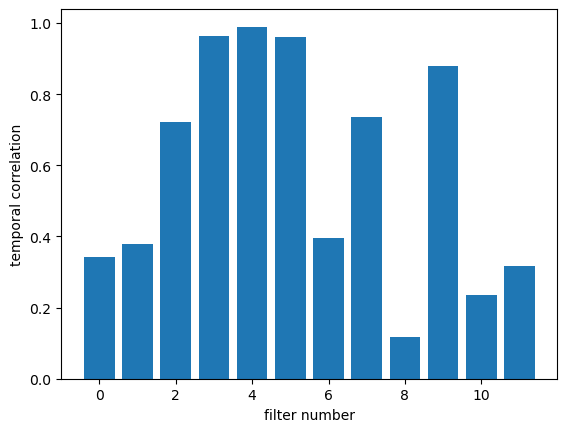

In [233]:
plt.bar(np.arange(0,12,1),temp_corr)
plt.xlabel('filter number')
plt.ylabel('temporal correlation')
plt.show()

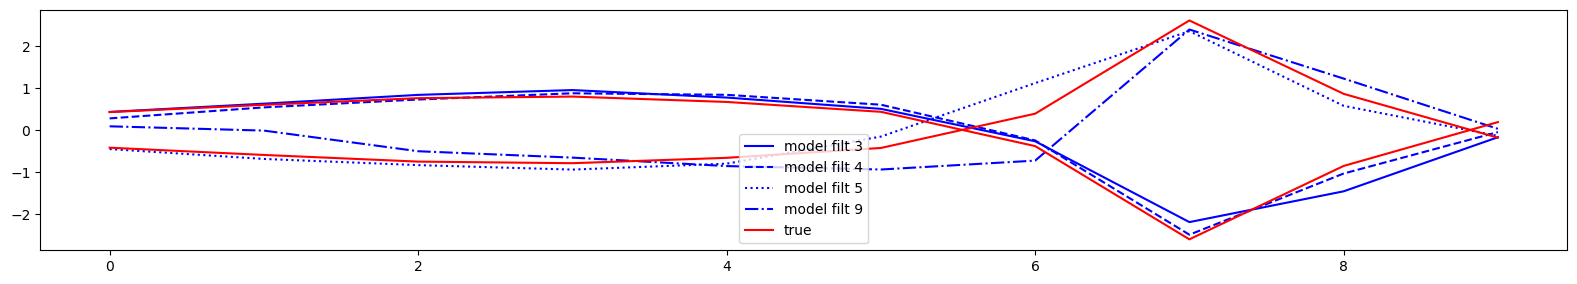

In [238]:
high_corr_idx = list(np.where(temp_corr>0.8)[0])
line_list = ['-', '--', ':', '-.']
ss()
for j in range(len(high_corr_idx)):
    i = high_corr_idx[j]
    plt.plot((pred_temp[:,i]-np.mean(pred_temp[:,i]))/np.std(pred_temp[:,i]), label='model filt '+str(i), color='blue', linestyle=line_list[j])

plt.plot(-1*(true_temp[::-1]-np.mean(true_temp))/np.std(true_temp),label='true', color='red')
plt.plot((true_temp[::-1]-np.mean(true_temp))/np.std(true_temp), color='red')
plt.legend()
plt.show()

## Redundancy?

In [43]:
model3 = deepcopy(models[str(num_LGN_units[2])+' LGN Units'])
print('Stim in shape:',data[0]['stim'].shape)
LGN_level_output = model3.networks[0].layers[0](data[0]['stim'])
print('LGN Level out shape:',LGN_level_output.shape)

Stim in shape: torch.Size([1000, 3600])
LGN Level out shape: torch.Size([1000, 10800])


In [44]:
model3.networks[0].layers[0].output_dims

[3, 60, 60, 1]

In [45]:
# Z-score across time dim
LGN_output_zscore = (LGN_level_output-torch.mean(LGN_level_output,axis=0))/torch.std(LGN_level_output,axis=0)
LGN_output_zscore.shape

torch.Size([1000, 10800])

In [46]:
# Reshape to output dims
LGN_output_zscore = LGN_output_zscore.reshape([data[0]['stim'].shape[0]]+model3.networks[0].layers[0].output_dims[:3]).detach().numpy()
LGN_output_zscore.shape

(1000, 3, 60, 60)

In [48]:
T = LGN_output_zscore.shape[0]
N = model3.networks[0].layers[0].output_dims[0] # num units
D = np.prod(model3.networks[0].layers[0].output_dims[1:])
output_corr = np.zeros((N,N))
for i in range(N):
    x_1 = LGN_output_zscore[:,i,L//2-1,L//2-1]
    for j in range(N):
        x_2 = LGN_output_zscore[:,j,:,:].reshape((T,D))
        output_corr[i,j] = np.max((x_2.T@x_1)/T)
print(output_corr.shape)

(3, 3)


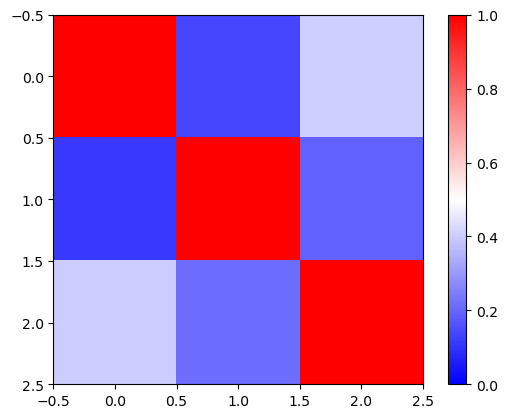

In [52]:
imagesc(output_corr, cmap='bwr')
plt.clim([0,1])
plt.colorbar()

In [61]:
model4 = deepcopy(models[str(num_LGN_units[3])+' LGN Units'])
print('Stim in shape:',data[0]['stim'].shape)
LGN_level_output = model4.networks[0].layers[0](data[0]['stim']).detach().numpy()
print('LGN Level out shape:',LGN_level_output.shape)

Stim in shape: torch.Size([1000, 3600])
LGN Level out shape: (1000, 14400)


In [62]:
model4.networks[0].layers[0].output_dims

[4, 60, 60, 1]

In [63]:
# Z-score across time dim
LGN_output_zscore = (LGN_level_output-np.mean(LGN_level_output,axis=0))/np.std(LGN_level_output,axis=0)
LGN_output_zscore[np.isnan(LGN_output_zscore)] = 0
LGN_output_zscore.shape

(1000, 14400)

In [64]:
# Reshape to output dims
LGN_output_zscore = LGN_output_zscore.reshape([data[0]['stim'].shape[0]]+model4.networks[0].layers[0].output_dims[:3])
LGN_output_zscore.shape

(1000, 4, 60, 60)

In [65]:
T = LGN_output_zscore.shape[0]
N = model4.networks[0].layers[0].output_dims[0] # num units
D = np.prod(model4.networks[0].layers[0].output_dims[1:])
output_corr = np.zeros((N,N))
for i in range(N):
    x_1 = LGN_output_zscore[:,i,L//2-1,L//2-1]
    for j in range(N):
        x_2 = LGN_output_zscore[:,j,:,:].reshape((T,D))
        output_corr[i,j] = np.max((x_2.T@x_1)/T)
print(output_corr.shape)

(4, 4)


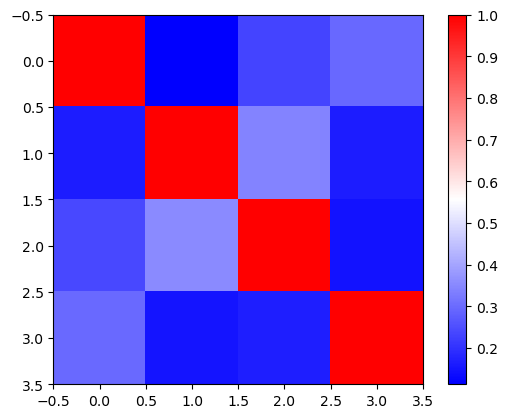

In [66]:
imagesc(output_corr, cmap='bwr')
#plt.clim([0,1])
plt.colorbar()

## Time Profile

In [67]:
model3_filters = model3.get_weights(ffnet_target=0,layer_target=0)
model3_filters.shape

(19, 19, 10, 3)

In [70]:
model3_filter_ts = model3_filters[fws[0]//2-1,fws[0]//2-1,:,:]
model3_filter_ts.shape

(10, 3)

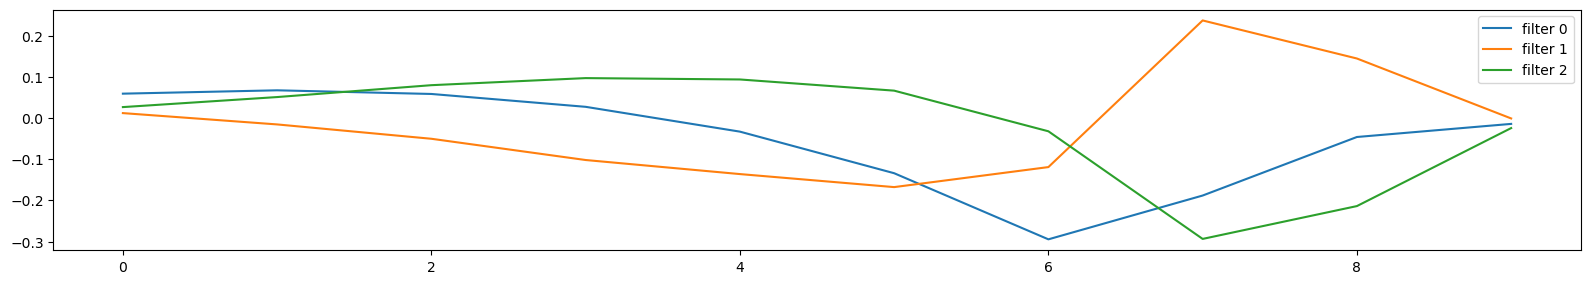

In [76]:
ss()
plt.plot(model3_filter_ts[:,0], label='filter 0')
plt.plot(model3_filter_ts[:,1], label='filter 1')
plt.plot(model3_filter_ts[:,2], label='filter 2')
plt.legend()
plt.show()

In [72]:
model4_filters = model4.get_weights(ffnet_target=0,layer_target=0)
model4_filters.shape

(19, 19, 10, 4)

In [73]:
model4_filter_ts = model4_filters[fws[0]//2-1,fws[0]//2-1,:,:]
model4_filter_ts.shape

(10, 4)

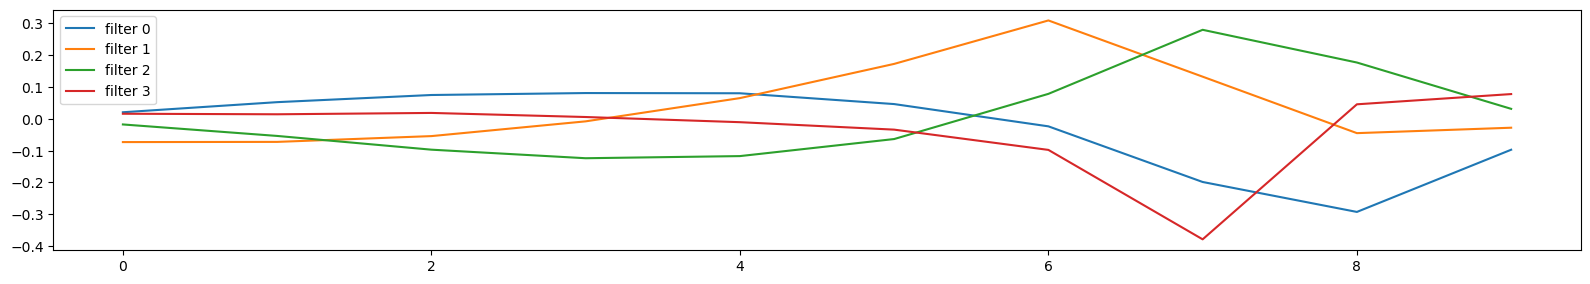

In [75]:
ss()
plt.plot(model4_filter_ts[:,0], label='filter 0')
plt.plot(model4_filter_ts[:,1], label='filter 1')
plt.plot(model4_filter_ts[:,2], label='filter 2')
plt.plot(model4_filter_ts[:,3], label='filter 3')
plt.legend()
plt.show()

## Save LGN models

In [60]:
for i in range(len(num_LGN_units)):
    cnn = models[str(num_LGN_units[i])+' LGN Units']
    cnn.save_model('models/LGN_testing_model_'+str(num_LGN_units[i])+'_units.ndn')

  Model saved:  models/LGN_testing_model_1_units.ndn
  Model saved:  models/LGN_testing_model_2_units.ndn
  Model saved:  models/LGN_testing_model_3_units.ndn
  Model saved:  models/LGN_testing_model_4_units.ndn
